# PROIECT - ETAPA 2


# Biblioteci necesare


In [1]:
import os
import random
import zipfile
import copy
import warnings
from collections import Counter
import shutil
from glob import glob
import itertools
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold


from PIL import Image
from torchvision import transforms
import cv2
from scipy.ndimage import gaussian_filter


import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

from torchsummary import summary


from sklearn.metrics import classification_report, confusion_matrix


## Extragere date

In [2]:
def extract_dataset(zip_path, extract_to):
    
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Datele au fost extrase în directorul: {extract_to}")
    else:
        print(f"Datele sunt deja extrase în directorul: {extract_to}")

extract_dataset(zip_path = 'data.zip',extract_to = 'data')

Datele sunt deja extrase în directorul: data


#  BrainTumorDataset

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = []
        self.labels = []

        for label, category in enumerate(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']):
            category_dir = os.path.join(root_dir, category)
            if os.path.exists(category_dir):
                for img_name in os.listdir(category_dir):
                    img_path = os.path.join(category_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        # lazy loading
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        
        # transformari
        if self.transform:
            image = self.transform(image)
        
        # label
        label = self.labels[idx]
        
        return image, label



## Impartirea setului de antrenare

In [4]:
from sklearn.model_selection import StratifiedKFold
from glob import glob
import os
import shutil

def k_fold_split_final(data_dir, categories, k=5, random_state=42):
    train_dir = os.path.join(data_dir, 'Training')
    k_fold_dir = os.path.join(data_dir, 'K_Folds')
    
    all_images = []
    labels = []
    
    # Collect all images and their corresponding labels
    for label, category in enumerate(categories):
        category_dir = os.path.join(train_dir, category)
        if os.path.exists(category_dir):
            images = glob(os.path.join(category_dir, '*'))
            all_images.extend(images)
            labels.extend([label] * len(images)) 
    
    if len(all_images) < k:
        print("Not enough images to apply K-Fold.")
        return
    
    # StratifiedKFold to maintain class proportions
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Create directories for storing fold data
    if os.path.exists(k_fold_dir):
        shutil.rmtree(k_fold_dir)
    os.makedirs(k_fold_dir, exist_ok=True)

    for fold, (train_idx, val_idx) in enumerate(skf.split(all_images, labels)):
        fold_train_dir = os.path.join(k_fold_dir, f'Fold_{fold + 1}', 'Train')
        fold_val_dir = os.path.join(k_fold_dir, f'Fold_{fold + 1}', 'Validation')
        
        # Create fold directories
        for dir_path in [fold_train_dir, fold_val_dir]:
            for category in categories:
                os.makedirs(os.path.join(dir_path, category), exist_ok=True)
        
        # Distribute images into fold directories
        for idx, img_path in enumerate(all_images):
            category = os.path.basename(os.path.dirname(img_path))
            if idx in train_idx:
                dest_path = os.path.join(fold_train_dir, category, os.path.basename(img_path))
            elif idx in val_idx:
                dest_path = os.path.join(fold_val_dir, category, os.path.basename(img_path))
            shutil.copy(img_path, dest_path)
        
        print(f"Fold {fold + 1}: Train={len(train_idx)} images, Validation={len(val_idx)} images")
    
    print(f"\nAll {k} folds have been created in the directory: {k_fold_dir}")

# Example usage
data_dir = 'data'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Split data into 5 folds
k_fold_split_final(data_dir, categories, k=5)


Fold 1: Train=2296 images, Validation=574 images
Fold 2: Train=2296 images, Validation=574 images
Fold 3: Train=2296 images, Validation=574 images
Fold 4: Train=2296 images, Validation=574 images
Fold 5: Train=2296 images, Validation=574 images

All 5 folds have been created in the directory: data/K_Folds


## Verificare si uniformizare

Numărul de imagini cu probleme în fiecare fold și în Testing:
Fold_1 - Train: 0 imagini cu canale non-uniforme, 2286 imagini cu dimensiuni non-uniforme
Fold_1 - Validation: 0 imagini cu canale non-uniforme, 569 imagini cu dimensiuni non-uniforme
Fold_2 - Train: 0 imagini cu canale non-uniforme, 2285 imagini cu dimensiuni non-uniforme
Fold_2 - Validation: 0 imagini cu canale non-uniforme, 570 imagini cu dimensiuni non-uniforme
Fold_3 - Train: 0 imagini cu canale non-uniforme, 2282 imagini cu dimensiuni non-uniforme
Fold_3 - Validation: 0 imagini cu canale non-uniforme, 573 imagini cu dimensiuni non-uniforme
Fold_4 - Train: 0 imagini cu canale non-uniforme, 2283 imagini cu dimensiuni non-uniforme
Fold_4 - Validation: 0 imagini cu canale non-uniforme, 572 imagini cu dimensiuni non-uniforme
Fold_5 - Train: 0 imagini cu canale non-uniforme, 2284 imagini cu dimensiuni non-uniforme
Fold_5 - Validation: 0 imagini cu canale non-uniforme, 571 imagini cu dimensiuni non-uniforme
Testing - 0 imagin

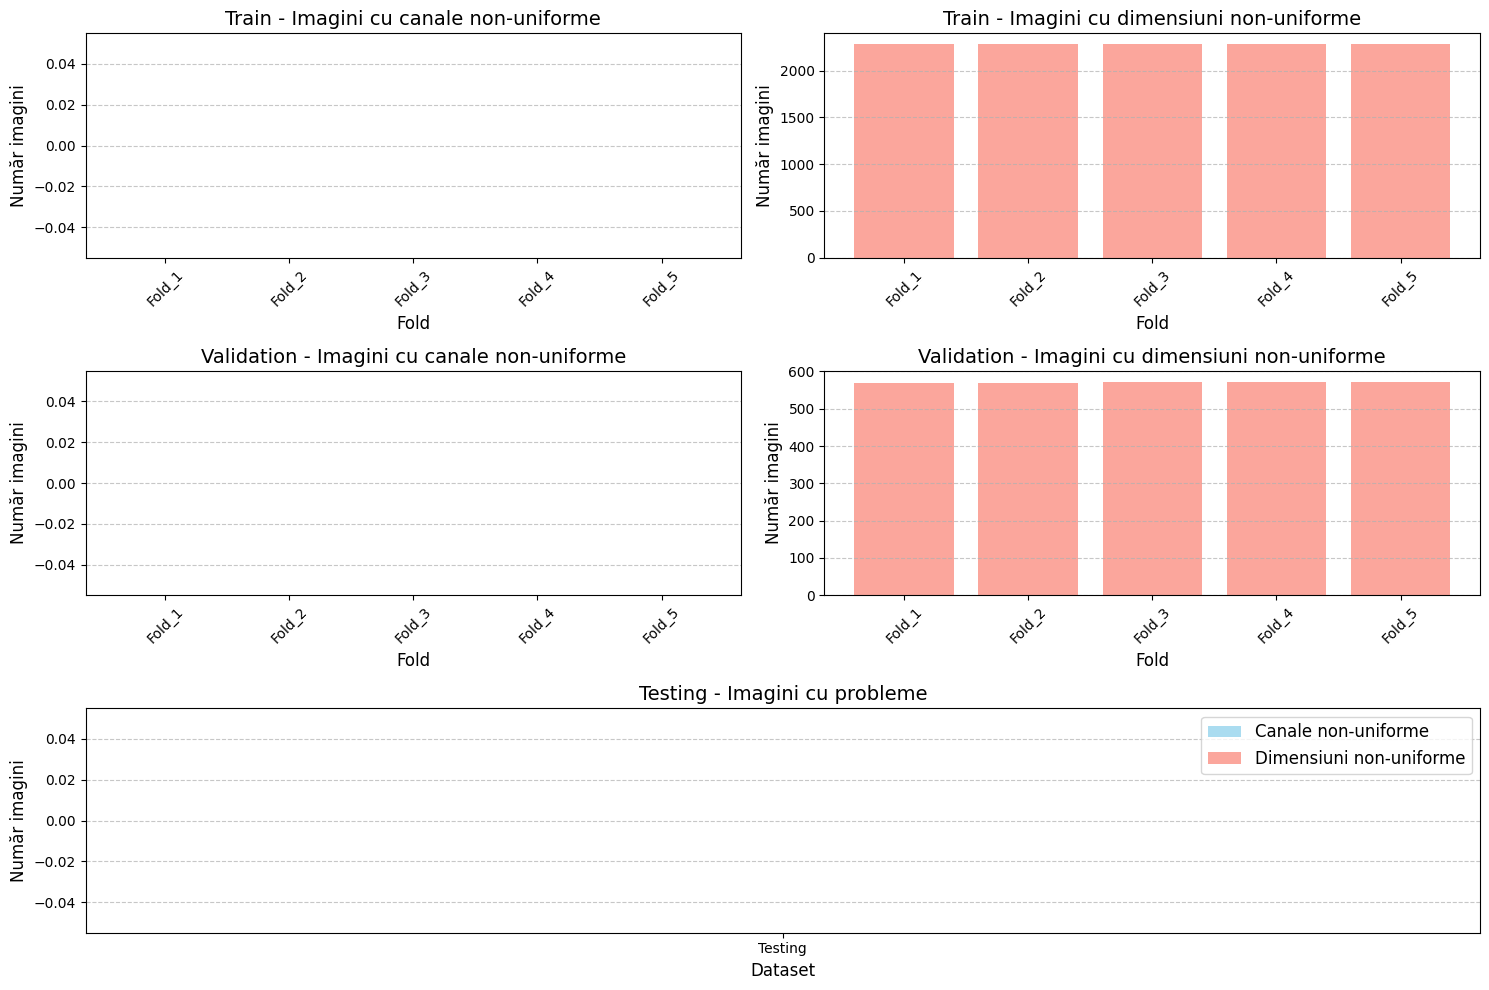

In [5]:
def check_and_fix_images_in_folds_and_testing(k_fold_dir, testing_dir, categories, target_size=(256, 256)):
    all_stats = {
        "Folds": {},
        "Testing": {'non_uniform_channels': 0, 'non_uniform_size': 0}
    }
    
    # Process Folds
    fold_paths = [os.path.join(k_fold_dir, fold) for fold in os.listdir(k_fold_dir) if os.path.isdir(os.path.join(k_fold_dir, fold))]

    for fold_path in fold_paths:
        stats = {
            'Train': {'non_uniform_channels': 0, 'non_uniform_size': 0},
            'Validation': {'non_uniform_channels': 0, 'non_uniform_size': 0}
        }

        for dataset_type in ['Train', 'Validation']:
            dataset_path = os.path.join(fold_path, dataset_type)
            for category in categories:
                category_path = os.path.join(dataset_path, category)
                images = glob(os.path.join(category_path, '*'))
                
                for img_path in images:
                    img = Image.open(img_path)
                    img_array = np.array(img)
                    
                    # Fix non-uniform channels
                    if img_array.ndim != 3:
                        img = Image.fromarray(img_array)
                        img = img.convert('RGB')
                        stats[dataset_type]['non_uniform_channels'] += 1
                        img_array = np.array(img)

                    # Fix non-uniform size
                    if img.size != target_size:
                        img = img.resize(target_size, Image.LANCZOS)
                        stats[dataset_type]['non_uniform_size'] += 1

                    # Normalize image
                    img_array = np.array(img) / 255.0
                    img.save(img_path)

        all_stats["Folds"][os.path.basename(fold_path)] = stats

    # Process Testing Dataset
    for category in categories:
        category_path = os.path.join(testing_dir, category)
        images = glob(os.path.join(category_path, '*'))

        for img_path in images:
            img = Image.open(img_path)
            img_array = np.array(img)
            
            # Fix non-uniform channels
            if img_array.ndim != 3:
                img = Image.fromarray(img_array)
                img = img.convert('RGB')
                all_stats["Testing"]['non_uniform_channels'] += 1
                img_array = np.array(img)

            # Fix non-uniform size
            if img.size != target_size:
                img = img.resize(target_size, Image.LANCZOS)
                all_stats["Testing"]['non_uniform_size'] += 1

            # Normalize image
            img_array = np.array(img) / 255.0
            img.save(img_path)

    return all_stats


# Paths and categories
k_fold_dir = os.path.join('data', 'K_Folds')
testing_dir = os.path.join('data', 'Testing')
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Check and fix images
report = check_and_fix_images_in_folds_and_testing(k_fold_dir, testing_dir, categories, target_size=(256, 256))

# Visualization
fold_labels = list(report["Folds"].keys())
train_non_uniform_channels = [report["Folds"][fold]['Train']['non_uniform_channels'] for fold in fold_labels]
val_non_uniform_channels = [report["Folds"][fold]['Validation']['non_uniform_channels'] for fold in fold_labels]
train_non_uniform_size = [report["Folds"][fold]['Train']['non_uniform_size'] for fold in fold_labels]
val_non_uniform_size = [report["Folds"][fold]['Validation']['non_uniform_size'] for fold in fold_labels]

testing_non_uniform_channels = report["Testing"]['non_uniform_channels']
testing_non_uniform_size = report["Testing"]['non_uniform_size']

print("Numărul de imagini cu probleme în fiecare fold și în Testing:")
for fold in fold_labels:
    print(f"{fold} - Train: {report['Folds'][fold]['Train']['non_uniform_channels']} imagini cu canale non-uniforme, "
          f"{report['Folds'][fold]['Train']['non_uniform_size']} imagini cu dimensiuni non-uniforme")
    print(f"{fold} - Validation: {report['Folds'][fold]['Validation']['non_uniform_channels']} imagini cu canale non-uniforme, "
          f"{report['Folds'][fold]['Validation']['non_uniform_size']} imagini cu dimensiuni non-uniforme")
print(f"Testing - {testing_non_uniform_channels} imagini cu canale non-uniforme, "
      f"{testing_non_uniform_size} imagini cu dimensiuni non-uniforme")

plt.figure(figsize=(15, 10))

# Folds - Train
plt.subplot(3, 2, 1)
plt.bar(fold_labels, train_non_uniform_channels, color='skyblue', alpha=0.7)
plt.title('Train - Imagini cu canale non-uniforme', fontsize=14)
plt.ylabel('Număr imagini', fontsize=12)
plt.xlabel('Fold', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 2, 2)
plt.bar(fold_labels, train_non_uniform_size, color='salmon', alpha=0.7)
plt.title('Train - Imagini cu dimensiuni non-uniforme', fontsize=14)
plt.ylabel('Număr imagini', fontsize=12)
plt.xlabel('Fold', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Folds - Validation
plt.subplot(3, 2, 3)
plt.bar(fold_labels, val_non_uniform_channels, color='skyblue', alpha=0.7)
plt.title('Validation - Imagini cu canale non-uniforme', fontsize=14)
plt.ylabel('Număr imagini', fontsize=12)
plt.xlabel('Fold', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 2, 4)
plt.bar(fold_labels, val_non_uniform_size, color='salmon', alpha=0.7)
plt.title('Validation - Imagini cu dimensiuni non-uniforme', fontsize=14)
plt.ylabel('Număr imagini', fontsize=12)
plt.xlabel('Fold', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Testing
plt.subplot(3, 1, 3)
plt.bar(['Testing'], [testing_non_uniform_channels], color='skyblue', alpha=0.7, label='Canale non-uniforme')
plt.bar(['Testing'], [testing_non_uniform_size], color='salmon', alpha=0.7, label='Dimensiuni non-uniforme')
plt.title('Testing - Imagini cu probleme', fontsize=14)
plt.ylabel('Număr imagini', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Preprocesare + normalizare

In [6]:
class PreprocessImageOptimized:
    def __init__(self):
        pass

    def __call__(self, img):
        
        # Încărcăm imaginea ca numpy array și o convertim la grayscale
        img = img.convert('L')
        img_array = np.array(img)

        # Skull-stripping (simulat prin praguri de intensitate)
        _, img_skull_stripped = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)
        img_brain_only = cv2.bitwise_and(img_array, img_skull_stripped)

        # Normalizarea intensității între [0, 1] și scalarea înapoi la [0, 255]
        img_normalized = (img_brain_only - np.min(img_brain_only)) / (np.max(img_brain_only) - np.min(img_brain_only))
        img_normalized = (img_normalized * 255).astype(np.uint8)

        # Filtru Gaussian pentru reducerea zgomotului
        img_smoothed = gaussian_filter(img_normalized, sigma=2)

        # Egalizarea histogramei pentru a îmbunătăți distribuția valorilor pixelilor
        img_hist_equalized = cv2.equalizeHist(img_smoothed)

        # CLAHE pentru îmbunătățirea contrastului
        clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_hist_equalized)
        
        # Filtru de detecție a marginilor (Sobel)
        sobelx = cv2.Sobel(img_clahe, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img_clahe, cv2.CV_64F, 0, 1, ksize=3)
        img_sobel = cv2.magnitude(sobelx, sobely)
        img_sobel = np.uint8(np.clip(img_sobel, 0, 255))

        # Convertim rezultatul final înapoi la PIL.Image
        img_final = Image.fromarray(img_clahe).convert('RGB')  

        return img_final        



## Pipeline-ul de transformări pentru fiecare imagine

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),           # Flip orizontal aleatoriu, cu probabilitatea 50%
    transforms.RandomVerticalFlip(p = 0.5),             # Flip vertical aleatoriu, cu probabilitatea 50%
    transforms.RandomRotation(degrees = 30),            # Rotire aleatorie în intervalul ±30 de grade
    PreprocessImageOptimized(),                         # Aplicăm preprocesarea optimizată
    transforms.ToTensor(),                              # Conversie în tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406],  # Normalizare pentru modele pre-antrenate
                         std = [0.229, 0.224, 0.225])
])



## ARHITECTURA

In [8]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin, win, conv, pool=2):
    # Get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    # Compute the output height and width after convolution
    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    # Apply pooling if specified
    if pool:
        hout = np.floor(hout / pool)
        wout = np.floor(wout / pool)
        
    return int(hout), int(wout)



## Definirea modelului

In [9]:
class CNN_BRAIN_TUMOR(nn.Module):
    def __init__(self, params):
        super(CNN_BRAIN_TUMOR, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(init_f)
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(2 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv2)
        
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(4 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv3)
        
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(8 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv4)
        
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = F.leaky_relu(self.bn1(self.conv1(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2)) 
        
        X = F.leaky_relu(self.bn2(self.conv2(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2)) 
        
        X = F.leaky_relu(self.bn3(self.conv3(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2)) 
        
        X = F.leaky_relu(self.bn4(self.conv4(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2))
        
        X = X.view(-1, self.num_flatten)
        X = F.dropout(F.relu(self.fc1(X)), self.dropout_rate, training=self.training)
        X = self.fc2(X)
        
        return X




## Incarcarea datelor

In [10]:
data_dir = 'data'
k_fold_dir = os.path.join(data_dir, 'K_Folds')
test_dir = os.path.join(data_dir, 'Testing')


# fold iter
fold_paths = [os.path.join(k_fold_dir, fold) for fold in os.listdir(k_fold_dir) if os.path.isdir(os.path.join(k_fold_dir, fold))]

# dataloaders list
fold_dataloaders = []

for fold_idx, fold_path in enumerate(fold_paths):
    print(f"Pregătire Fold {fold_idx + 1}/{len(fold_paths)}")
    
    # train, val, test  datasets
    train_dataset = BrainTumorDataset(root_dir=os.path.join(fold_path, 'Train'), transform=transform)
    val_dataset = BrainTumorDataset(root_dir=os.path.join(fold_path, 'Validation'), transform=transform)
    test_dataset = BrainTumorDataset(root_dir=test_dir, transform=transform)
    
    # train, val, test dataloaders
    train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    fold_dataloaders.append((train_dl, val_dl, test_dl))

for fold_idx, (train_dl, val_dl, test_dl) in enumerate(fold_dataloaders):
    print(f"Fold {fold_idx + 1}:")
    print(f"- Train DataLoader: {len(train_dl.dataset)} imagini")
    print(f"- Validation DataLoader: {len(val_dl.dataset)} imagini")
    print(f"- Test DataLoader: {len(test_dl.dataset)} imagini")


Pregătire Fold 1/5
Pregătire Fold 2/5
Pregătire Fold 3/5
Pregătire Fold 4/5
Pregătire Fold 5/5
Fold 1:
- Train DataLoader: 2296 imagini
- Validation DataLoader: 574 imagini
- Test DataLoader: 394 imagini
Fold 2:
- Train DataLoader: 2296 imagini
- Validation DataLoader: 574 imagini
- Test DataLoader: 394 imagini
Fold 3:
- Train DataLoader: 2296 imagini
- Validation DataLoader: 574 imagini
- Test DataLoader: 394 imagini
Fold 4:
- Train DataLoader: 2296 imagini
- Validation DataLoader: 574 imagini
- Test DataLoader: 394 imagini
Fold 5:
- Train DataLoader: 2296 imagini
- Validation DataLoader: 574 imagini
- Test DataLoader: 394 imagini


## Instantierea retelei + rularea pe GPU

In [11]:
params_model={
        "shape_in": (3, 256, 256), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 4
}

cnn_model = CNN_BRAIN_TUMOR(params_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Modelul rulează pe {device}")

model = cnn_model.to(device)


summary(cnn_model, input_size=(3, 256, 256), device = device.type)

Modelul rulează pe cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             608
       BatchNorm2d-2          [-1, 8, 256, 256]              16
            Conv2d-3         [-1, 16, 128, 128]           3,216
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5           [-1, 32, 64, 64]          12,832
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 32, 32]          51,264
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Linear-9                  [-1, 100]       1,638,500
           Linear-10                    [-1, 4]             404
Total params: 1,707,064
Trainable params: 1,707,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 15.00
Param

## Loss Function + Adam optimizer

In [12]:
loss_func = nn.CrossEntropyLoss()

opt = optim.AdamW(cnn_model.parameters(), lr=3e-4)

lr_scheduler = OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=2296, epochs=20)


# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt = None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim = 1, keepdim = True) # Get Output Class
    metric_b = pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, opt = None):
    
    run_loss = 0.0 
    t_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb = xb.to(device)
        yb = yb.to(device)
        
        output = model(xb) # get model output
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss += loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric += metric_b    
    
    loss = run_loss / float(len_data)  # average loss value
    metric = t_metric / float(len_data) # average metric value
    
    return loss, metric


## Antrenarea modelului

In [13]:
def Train_Val(model, params, verbose = False):
    
    # Get the parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # history of loss values in each epoch
    loss_history = {"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history = {"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss = float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in range(epochs):
        
        # Get the Learning Rate
        current_lr = get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100 * val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [14]:
def Ture_and_Pred(val_loader, model):
    
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    return y_true, y_pred


## Functii de plotare

In [15]:
def plot_classification_report(y_true, y_pred, title='Overall Classification Metrics'):
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    overall_metrics = {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1-score": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"]
    }
    
    df_overall = pd.DataFrame(overall_metrics, index=["Score"]).T

    plt.figure(figsize=(6, 4))
    sns.heatmap(df_overall, annot=True, cmap="Blues", fmt='.2f', cbar=False)
    plt.title(title)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10, 7))
    plt.grid(False)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(CLA_label))
    plt.xticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()])

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}\n{cm[i, j] / np.sum(cm) * 100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

def plot_train_val_graphs(loss_history, metric_history):
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history["train"], label = "Train Loss")
    plt.plot(loss_history["val"], label = "Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metric_history["train"], label = "Train Accuracy")
    plt.plot(metric_history["val"], label = "Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


## Antrenare, validare si testare

In [16]:
fold_results = []

for fold_idx, (train_dl, val_dl, test_dl) in enumerate(fold_dataloaders):
    print(f"\nAntrenare Fold {fold_idx + 1}/{len(fold_dataloaders)}")
    
    
    # params for train
    params = {
        "epochs": 20,
        "f_loss": loss_func,
        "optimiser": opt,
        "train": train_dl,
        "val": val_dl,
        "test": test_dl,
        "lr_change": lr_scheduler,
        "weight_path": f"./best_model_fold_{fold_idx + 1}.pth",
    }
    
    # train
    trained_model, loss_history, metric_history = Train_Val(cnn_model, params, verbose=True)
    
    # eval on data set
    y_true, y_pred = Ture_and_Pred(test_dl, trained_model)
    
    fold_results.append({
        "fold": fold_idx + 1,
        "trained_model": trained_model,
        "loss_history": loss_history,
        "metric_history": metric_history,
        "val": val_dl,

        "y_true": y_true,
        "y_pred": y_pred
    })
    
    print(f"\nFold {fold_idx + 1} antrenat și evaluat.\n")



Antrenare Fold 1/5
Epoch 0/19, current lr=3.9999999999999996e-05
Copied best model weights!
Loading best model weights!
train loss: 0.036576, dev loss: 0.032141, accuracy: 55.40
----------
Epoch 1/19, current lr=4.0000000012895714e-05
Copied best model weights!
Loading best model weights!
train loss: 0.031147, dev loss: 0.028929, accuracy: 60.28
----------
Epoch 2/19, current lr=4.0000000010446827e-05
Copied best model weights!
Loading best model weights!
train loss: 0.027838, dev loss: 0.025856, accuracy: 67.42
----------
Epoch 3/19, current lr=4.0000000008345534e-05
Copied best model weights!
Loading best model weights!
train loss: 0.025238, dev loss: 0.023690, accuracy: 69.16
----------
Epoch 4/19, current lr=4.000000000700557e-05
Copied best model weights!
Loading best model weights!
train loss: 0.023124, dev loss: 0.022006, accuracy: 72.13
----------
Epoch 5/19, current lr=4.000000000604486e-05
Copied best model weights!
Loading best model weights!
train loss: 0.021634, dev loss:

## Plotare


Rezultate pentru Fold 1:


Fold 1 - Raport de clasificare



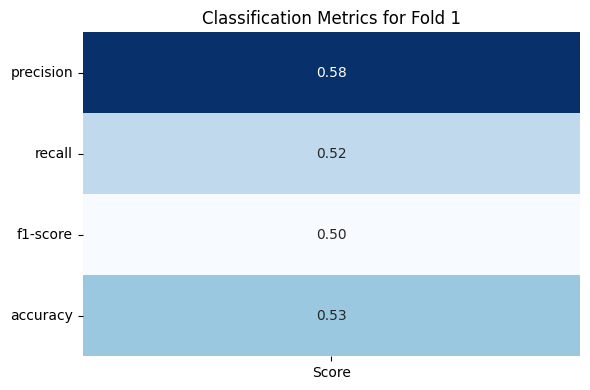

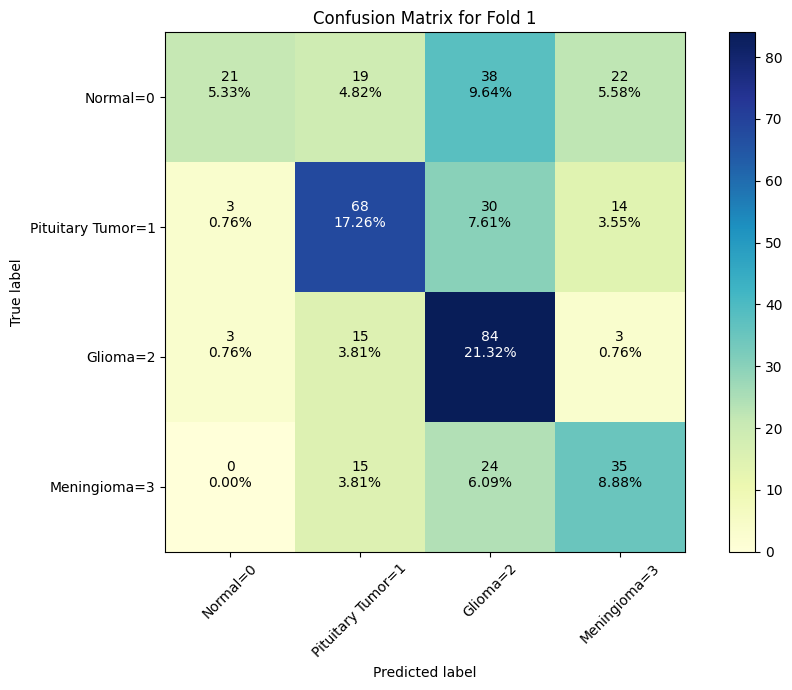


Fold 1 - Evolutia pierderii si acuratetei



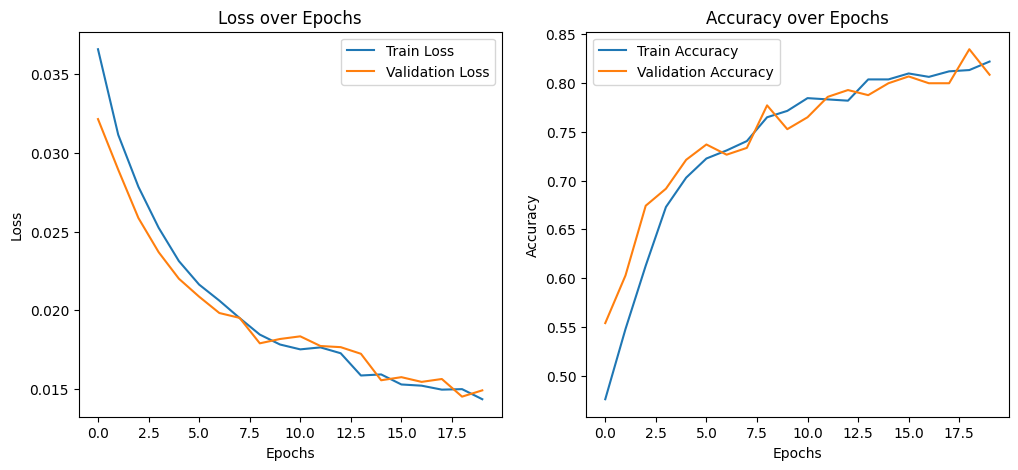


Rezultate pentru Fold 2:


Fold 2 - Raport de clasificare



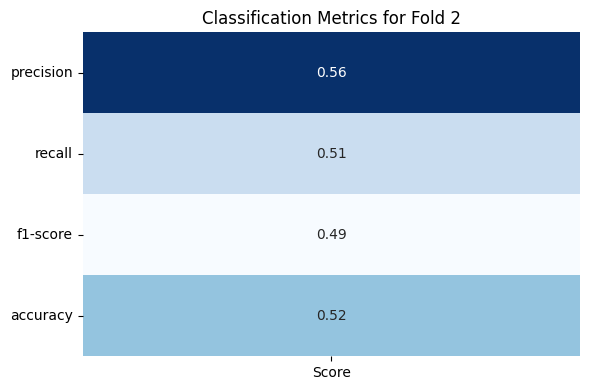

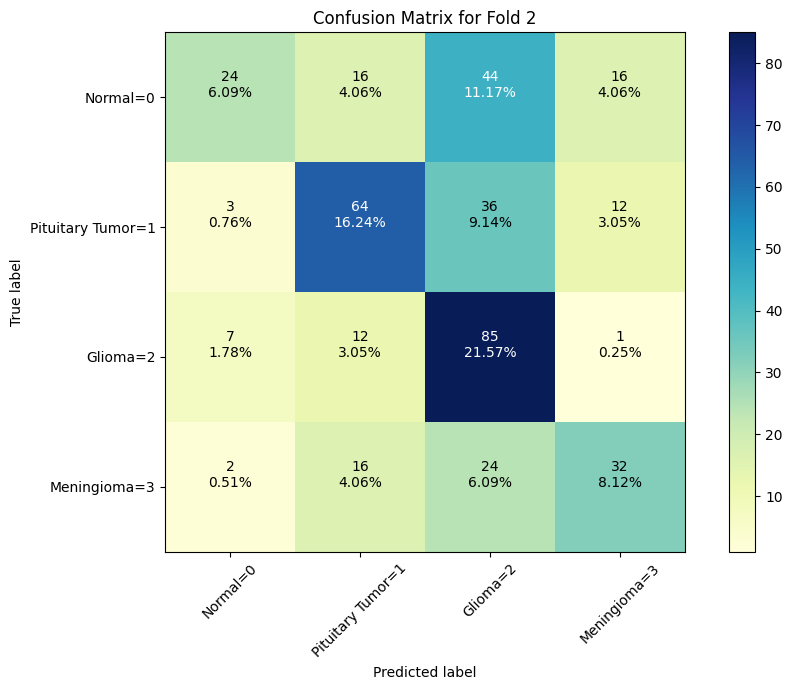


Fold 2 - Evolutia pierderii si acuratetei



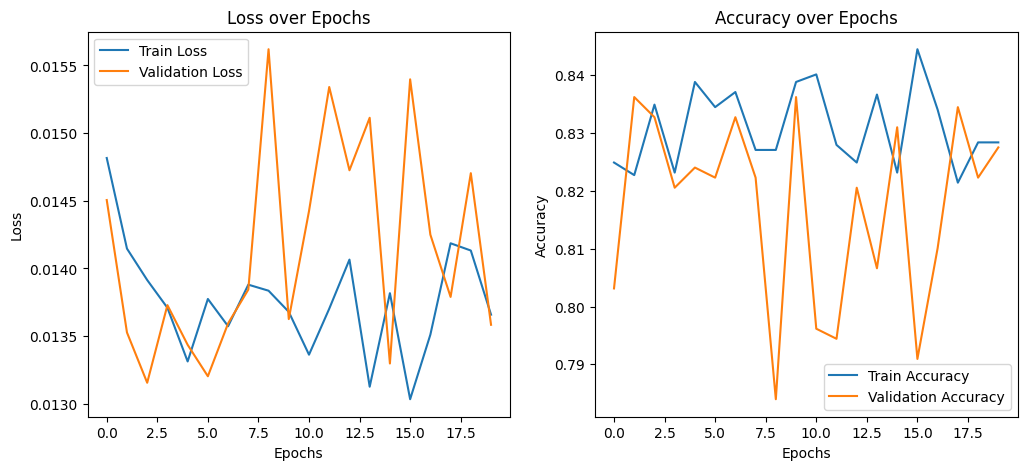


Rezultate pentru Fold 3:


Fold 3 - Raport de clasificare



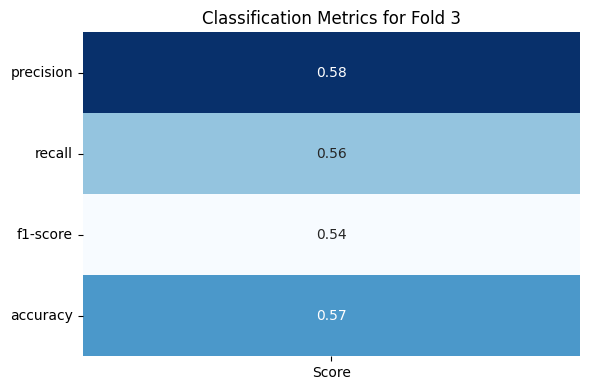

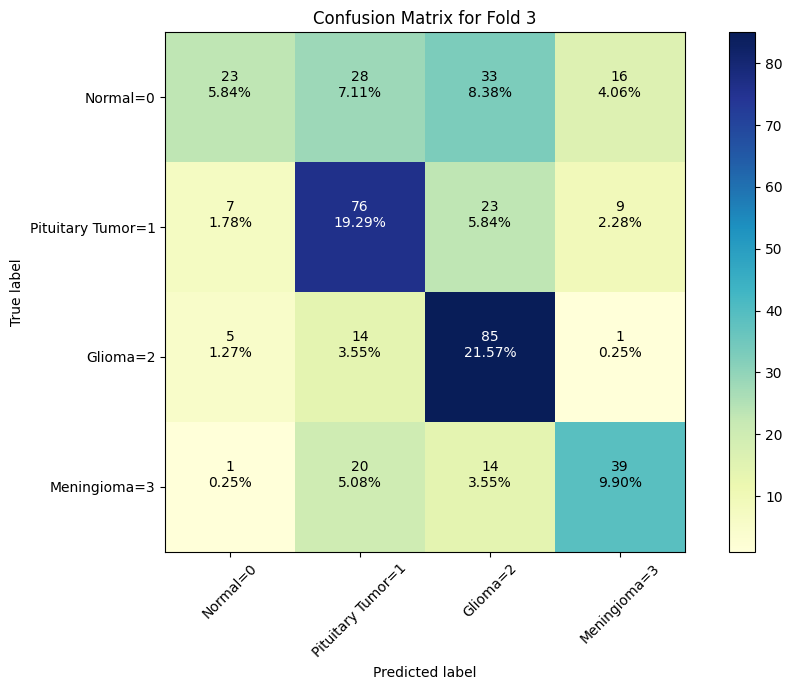


Fold 3 - Evolutia pierderii si acuratetei



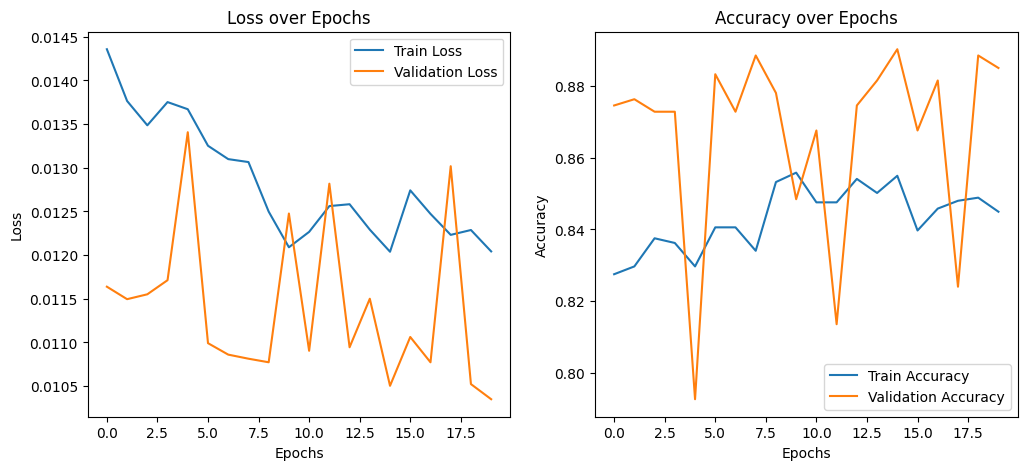


Rezultate pentru Fold 4:


Fold 4 - Raport de clasificare



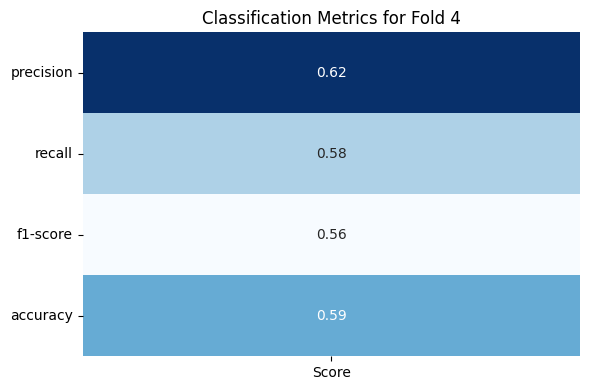

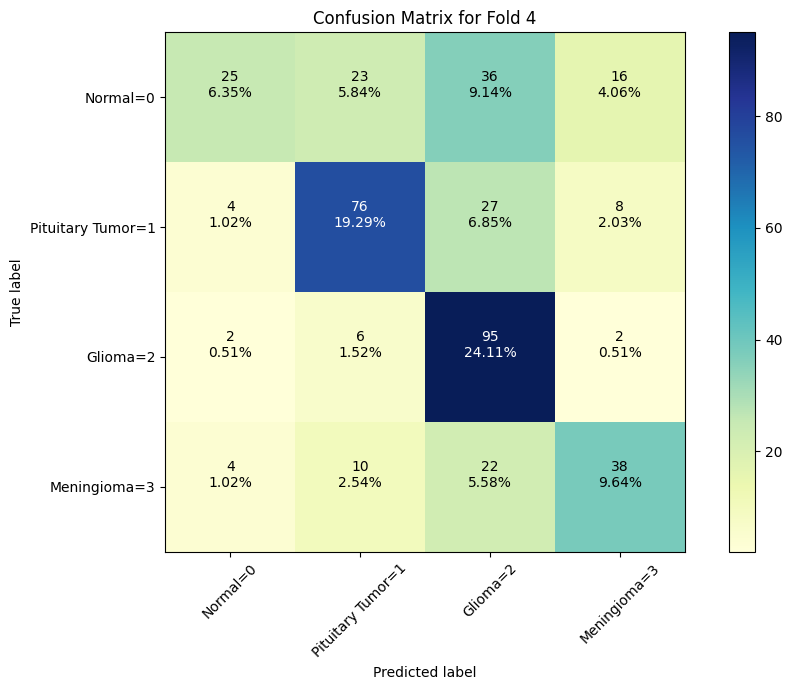


Fold 4 - Evolutia pierderii si acuratetei



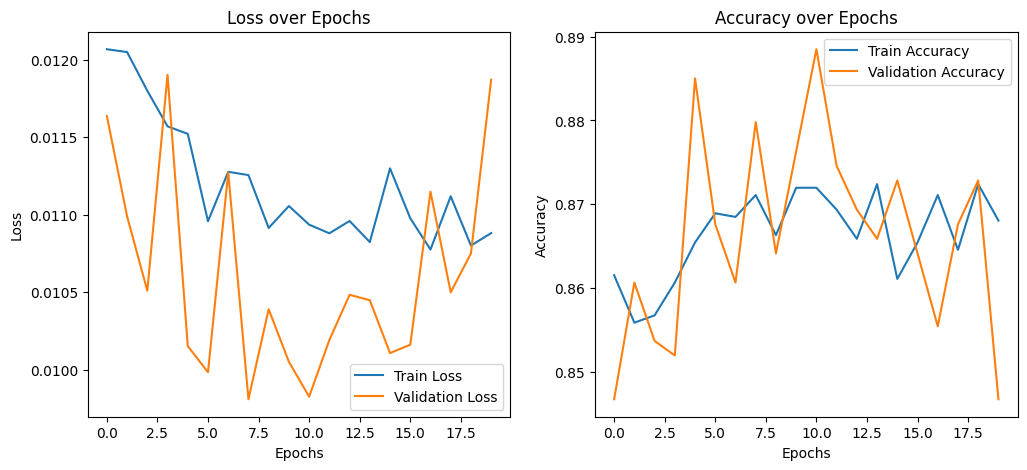


Rezultate pentru Fold 5:


Fold 5 - Raport de clasificare



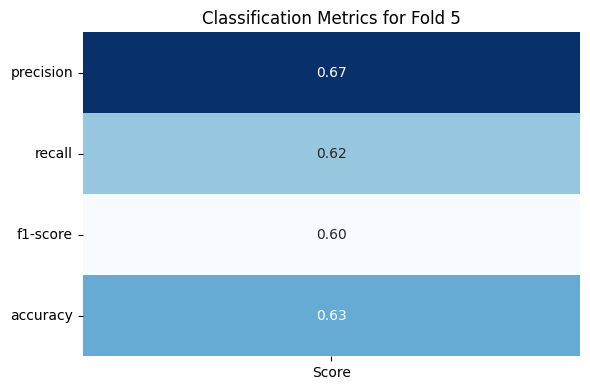

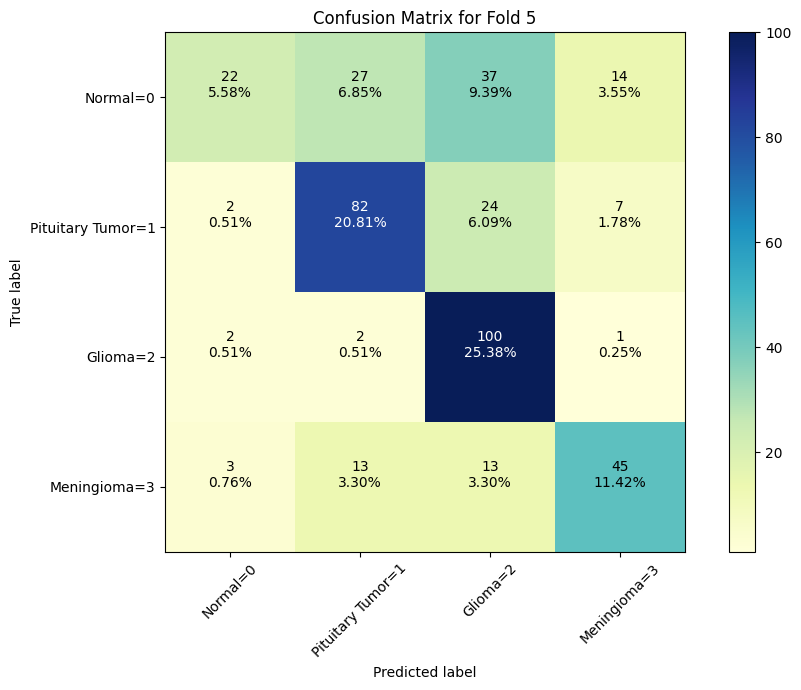


Fold 5 - Evolutia pierderii si acuratetei



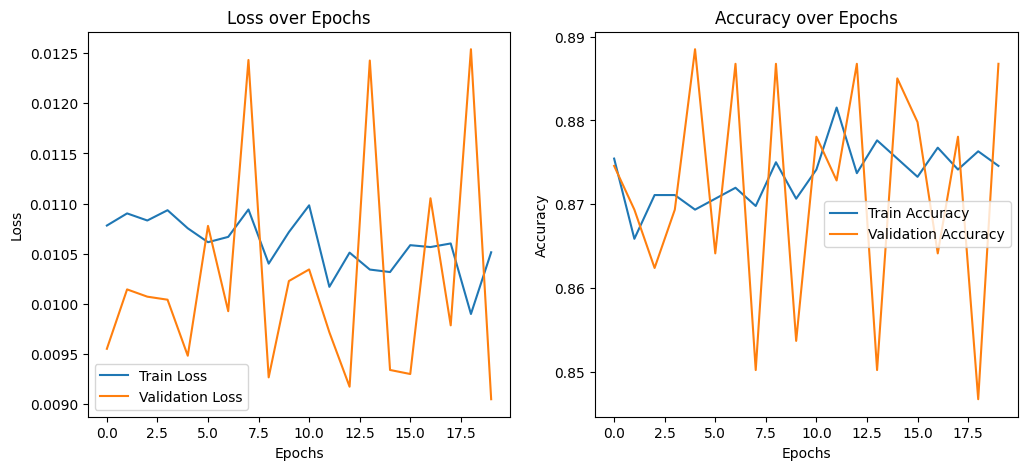

In [17]:


CLA_label = {
    0: "Normal",
    1: "Pituitary Tumor",
    2: "Glioma",
    3: "Meningioma"
}

for result in fold_results:
    fold = result["fold"]
    print(f"\nRezultate pentru Fold {fold}:\n")
    
    y_true = result["y_true"]
    y_pred = result["y_pred"]
    loss_history = result["loss_history"]
    metric_history = result["metric_history"]
    
    print(f"\nFold {fold} - Raport de clasificare\n")
    plot_classification_report(y_true, y_pred, title=f"Classification Metrics for Fold {fold}")
    
    cm = confusion_matrix(y_true, y_pred)
    show_confusion_matrix(cm, CLA_label, title=f"Confusion Matrix for Fold {fold}")
    
    print(f"\nFold {fold} - Evolutia pierderii si acuratetei\n")
    plot_train_val_graphs(loss_history, metric_history)


## Finalizarea foldurilor - Tabel

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

fold_metrics = []

for result in fold_results:
    fold = result["fold"]
    y_true_test = result["y_true"]  # test true labels
    y_pred_test = result["y_pred"]  # test predictions
    
    # val
    y_true_val, y_pred_val = Ture_and_Pred(params["val"], result["trained_model"])
    
    # metrics for testing
    precision_test = precision_score(y_true_test, y_pred_test, average="macro")
    recall_test = recall_score(y_true_test, y_pred_test, average="macro")
    f1_test = f1_score(y_true_test, y_pred_test, average="macro")
    accuracy_test = accuracy_score(y_true_test, y_pred_test)
    
    # metrics for validation
    precision_val = precision_score(y_true_val, y_pred_val, average="macro")
    recall_val = recall_score(y_true_val, y_pred_val, average="macro")
    f1_val = f1_score(y_true_val, y_pred_val, average="macro")
    accuracy_val = accuracy_score(y_true_val, y_pred_val)
    
    # metrics for fold
    fold_metrics.append({
        "Fold": fold,
        "Precision_Validation": precision_val,
        "Recall_Validation": recall_val,
        "F1-Score_Validation": f1_val,
        "Accuracy_Validation": accuracy_val,
        "Precision_Test": precision_test,
        "Recall_Test": recall_test,
        "F1-Score_Test": f1_test,
        "Accuracy_Test": accuracy_test
    })


metrics_df = pd.DataFrame(fold_metrics)

# mean and std for metrics
metrics_summary_validation = metrics_df.filter(like="Validation").describe().loc[["mean", "std"]]
metrics_summary_test = metrics_df.filter(like="Test").describe().loc[["mean", "std"]]

print("\nRezultate Fold-uri (Validare si Testare):")
print(metrics_df)

# mean and std for val and test
print("\nMedii si Deviatii Standard pentru Validare:")
print(metrics_summary_validation)

print("\nMedii si Deviatii Standard pentru Testare:")
print(metrics_summary_test)

metrics_df.to_csv("fold_metrics_validation_and_test.csv", index=False)



Rezultate Fold-uri (Validare si Testare):
   Fold  Precision_Validation  Recall_Validation  F1-Score_Validation  \
0     1              0.900170           0.899046             0.899139   
1     2              0.898937           0.896150             0.896973   
2     3              0.901854           0.906899             0.903949   
3     4              0.900082           0.900445             0.899797   
4     5              0.889452           0.892976             0.890389   

   Accuracy_Validation  Precision_Test  Recall_Test  F1-Score_Test  \
0             0.895470        0.577305     0.518569       0.496938   
1             0.890244        0.558396     0.509619       0.494809   
2             0.900697        0.584500     0.556855       0.538506   
3             0.898955        0.624171     0.582286       0.562158   
4             0.888502        0.666566     0.623383       0.595605   

   Accuracy_Test  
0       0.527919  
1       0.520305  
2       0.565990  
3       0.593909  
4 

## Balansare (Cerinta 2)

In [19]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from collections import Counter


from torchvision import transforms

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),           # Flip orizontal aleatoriu, prob 50%
    transforms.RandomVerticalFlip(p = 0.5),             # Flip vertical aleatoriu, cu prob 50%
    transforms.RandomRotation(degrees = 30),            # Rotire aleatorie în intervalul ±30 de grade
    # PreprocessImageOptimized(),                        
    transforms.ToTensor(),                              # Conversie în tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406],  # Normalizare pentru modele pre-antrenate
                         std = [0.229, 0.224, 0.225])
])

# weights of classes
def calculate_class_weights(labels, device):
    class_counts = Counter(labels)  
    num_classes = len(class_counts)
    class_weights = [1.0 / class_counts[i] for i in range(num_classes)]
    print(f"Distributia claselor în fold: {class_counts}")
    print(f"Ponderile claselor: {class_weights}")
    return torch.tensor(class_weights, dtype=torch.float32, device=device)

def create_oversampled_dataloader(dataset, batch_size, with_augmentation=False):
    print(f"Dimensiunea initiala a datasetului: {len(dataset.image_paths)} imagini.")

    class_counts_dict = Counter(dataset.labels)
    num_classes = len(class_counts_dict)
    class_counts = [class_counts_dict[i] for i in range(num_classes)]
    max_count = max(class_counts)  
    print(f"Distribuția claselor: {class_counts}")

    # gen ex for minoritary classes
    new_image_paths = []
    new_labels = []

    for label in range(num_classes):
        indices = [i for i, lbl in enumerate(dataset.labels) if lbl == label]
        if not indices:
            print(f"Clasa {label} nu are exemple. Continuăm cu alte clase.")
            continue

        original_image_paths = [dataset.image_paths[i] for i in indices]
        original_labels = [label] * len(indices)

        # calc how many ex we need
        num_to_add = max_count - len(indices)
        sampled_image_paths = [original_image_paths[i % len(original_image_paths)] for i in range(num_to_add)]
        sampled_labels = [label] * num_to_add

        # add orig and dub data
        new_image_paths.extend(original_image_paths + sampled_image_paths)
        new_labels.extend(original_labels + sampled_labels)

    dataset.image_paths = new_image_paths
    dataset.labels = new_labels

    print(f"Noua dimensiune a datasetului: {len(dataset.image_paths)} imagini.")

    if not with_augmentation:
        dataset.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # dataloader without samplet for balansed data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

scenarios = [
    {"name": "No Balancing", "loss_func": nn.CrossEntropyLoss(), "oversampling": False},
    {"name": "Weighted Loss", "loss_func": None, "oversampling": False},  
    {"name": "Oversampling with Augmentation", "loss_func": nn.CrossEntropyLoss(), "oversampling": True, "augmentation": True},
    {"name": "Oversampling without Augmentation", "loss_func": nn.CrossEntropyLoss(), "oversampling": True, "augmentation": False},
]

all_fold_results = []

for fold_idx in range(5):
    print(f"\nEvaluare pe Foldul {fold_idx + 1}")
    fold_results = []

    for scenario in scenarios:
        print(f"\nExperiment: {scenario['name']} - Fold {fold_idx + 1}")

        train_dl, val_dl, test_dl = fold_dataloaders[fold_idx]

        if scenario["name"] == "Weighted Loss":
            train_labels = []
            for xb, yb in train_dl:
                train_labels.extend(yb.tolist())
            class_weights = calculate_class_weights(train_labels, device)
            loss_func = nn.CrossEntropyLoss(weight=class_weights)
        else:
            loss_func = scenario["loss_func"]

        if scenario["oversampling"]:
            train_dl = create_oversampled_dataloader(train_dataset, batch_size=32, with_augmentation=scenario.get("augmentation", False))

        opt = torch.optim.AdamW(cnn_model.parameters(), lr=3e-4)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=len(train_dl), epochs=15)

        params = {
            "epochs": 15,
            "f_loss": loss_func,
            "optimiser": opt,
            "train": train_dl,
            "val": val_dl,
            "test": test_dl,
            "lr_change": lr_scheduler,
            "weight_path": f"./best_model_fold_{fold_idx + 1}_{scenario['name']}.pth",
        }

        trained_model, loss_history, metric_history = Train_Val(cnn_model, params, verbose=True)

        y_true, y_pred = Ture_and_Pred(test_dl, trained_model)

        fold_results.append({
            "scenario": scenario["name"],
            "fold": fold_idx + 1,
            "trained_model": trained_model,
            "loss_history": loss_history,
            "metric_history": metric_history,
            "y_true": y_true,
            "y_pred": y_pred
        })

    all_fold_results.extend(fold_results)

scenario_results = {}

for result in all_fold_results:
    scenario = result["scenario"]
    fold = result["fold"]
    y_true = result["y_true"]
    y_pred = result["y_pred"]

    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)

    if scenario not in scenario_results:
        scenario_results[scenario] = []

    scenario_results[scenario].append({
        "Fold": fold,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": accuracy
    })

final_results = []

for scenario, results in scenario_results.items():
    for res in results:
        final_results.append({"Scenario": scenario, **res})

results_df = pd.DataFrame(final_results)
print("\nRezultate finale pentru toate foldurile:")
print(results_df)

# save to csv
results_df.to_csv("all_scenario_results.csv", index=False)




Evaluare pe Foldul 1

Experiment: No Balancing - Fold 1
Epoch 0/14, current lr=3.9999999999999996e-05
Copied best model weights!
Loading best model weights!
train loss: 0.010925, dev loss: 0.009851, accuracy: 88.50
----------
Epoch 1/14, current lr=4.000000220320376e-05
Loading best model weights!
train loss: 0.010363, dev loss: 0.009948, accuracy: 88.15
----------
Epoch 2/14, current lr=4.0000002247020925e-05
Copied best model weights!
Loading best model weights!
train loss: 0.010048, dev loss: 0.008442, accuracy: 90.24
----------
Epoch 3/14, current lr=4.000000161818269e-05
Loading best model weights!
train loss: 0.010112, dev loss: 0.009310, accuracy: 88.33
----------
Epoch 4/14, current lr=4.000000196802448e-05
Loading best model weights!
train loss: 0.010174, dev loss: 0.010093, accuracy: 88.68
----------
Epoch 5/14, current lr=4.000000231307388e-05
Loading best model weights!
train loss: 0.009693, dev loss: 0.009039, accuracy: 89.20
----------
Epoch 6/14, current lr=4.0000001855

## Monai augemntation


In [393]:
from monai.transforms import (
    Compose, LoadImageD, Resized, ScaleIntensityD,
    RandFlipD, EnsureTypeD, ToTensorD,
    RandGaussianNoiseD,RandRotateD,RandGridDistortionD
)

augmentations = {
    "Basic": Compose([
        LoadImageD(keys=["image"], image_only=True, dtype=np.float32, ensure_channel_first=True),
        Resized(keys=["image"], spatial_size=(256, 256)),
        ScaleIntensityD(keys=["image"]),
        EnsureTypeD(keys=["image", "label"]),
        ToTensorD(keys=["image", "label"]),
    ]),
    "Flip & Noise": Compose([
        LoadImageD(keys=["image"], image_only=True, dtype=np.float32, ensure_channel_first=True),
        Resized(keys=["image"], spatial_size=(256, 256)),
        ScaleIntensityD(keys=["image"]),
        RandFlipD(keys=["image"], prob=0.5, spatial_axis=0),
        RandFlipD(keys=["image"], prob=0.5, spatial_axis=1),
        RandGaussianNoiseD(keys=["image"], prob=0.5, mean=0.0, std=0.1),
        EnsureTypeD(keys=["image", "label"]),
        ToTensorD(keys=["image", "label"]),
    ]),
    "Rotation & Elastic": Compose([
        LoadImageD(keys=["image"], image_only=True, dtype=np.float32, ensure_channel_first=True),
        Resized(keys=["image"], spatial_size=(256, 256)),
        ScaleIntensityD(keys=["image"]),
        RandRotateD(keys=["image"], range_x=30, prob=0.5),
        RandGridDistortionD(keys=["image"], prob=0.5, distort_limit=0.2),
        EnsureTypeD(keys=["image", "label"]),
        ToTensorD(keys=["image", "label"]),
    ]),
}




In [394]:
def load_fold_dataloaders(k_fold_dir, test_dir, categories, transform=None, batch_size=32):
    """
    incarca foldurile K-fold si genereaza DataLoader-e pentru train, validation si test.
    """
    fold_paths = [
        os.path.join(k_fold_dir, fold)
        for fold in sorted(os.listdir(k_fold_dir))
        if os.path.isdir(os.path.join(k_fold_dir, fold))
    ]

    fold_dataloaders = []

    for fold_path in fold_paths:
        print(f"Pregătire Fold: {os.path.basename(fold_path)}")

        # load images and labels
        train_data = [
            {"image": os.path.join(category_path, img_name), "label": label}
            for label, category in enumerate(categories)
            for category_path in [os.path.join(fold_path, 'Train', category)]
            if os.path.exists(category_path)
            for img_name in os.listdir(category_path)
        ]

        val_data = [
            {"image": os.path.join(category_path, img_name), "label": label}
            for label, category in enumerate(categories)
            for category_path in [os.path.join(fold_path, 'Validation', category)]
            if os.path.exists(category_path)
            for img_name in os.listdir(category_path)
        ]

        test_data = [
            {"image": os.path.join(category_path, img_name), "label": label}
            for label, category in enumerate(categories)
            for category_path in [os.path.join(test_dir, category)]
            if os.path.exists(category_path)
            for img_name in os.listdir(category_path)
        ]

        # MONAI dataset
        train_dataset = Dataset(data=train_data, transform=transform)
        val_dataset = Dataset(data=val_data, transform=transform)
        test_dataset = Dataset(data=test_data, transform=transform)

        # dataloaders
        train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        fold_dataloaders.append((train_dl, val_dl, test_dl))

    print(f"Au fost incarcate {len(fold_dataloaders)} folduri.")
    return fold_dataloaders



In [395]:
def Ture_and_Pred(test_loader, model):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(next(model.parameters()).device)  
            labels = batch["label"].to(next(model.parameters()).device)

            outputs = model(images)

            probabilities = F.softmax(outputs, dim=1)

            # predictions for maximum probability class
            preds = probabilities.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    return y_true, y_pred, y_scores


In [396]:
from sklearn.metrics import roc_auc_score


def train_and_evaluate(model, fold_dataloaders, augmentation_name, augmentation, epochs=10, device="cuda"):
    results = []

    for fold_idx, (train_dl, val_dl, test_dl) in enumerate(fold_dataloaders):
        print(f"\nAntrenare Fold {fold_idx + 1}/{len(fold_dataloaders)} cu augmentarea '{augmentation_name}'")

        train_ds = Dataset(
            data=[{"image": img["image"], "label": img["label"]} for img in train_dl.dataset.data],
            transform=augmentation,
        )
        val_ds = Dataset(
            data=[{"image": img["image"], "label": img["label"]} for img in val_dl.dataset.data],
            transform=augmentation,
        )
        test_ds = Dataset(
            data=[{"image": img["image"], "label": img["label"]} for img in test_dl.dataset.data],
            transform=augmentation,
        )

        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

        # optimizer , scheduler
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=epochs
        )

        # loss function
        loss_func = torch.nn.CrossEntropyLoss()

        # train
        model, loss_history, metric_history = Train_Val(
            model,
            params={
                "epochs": epochs,
                "f_loss": loss_func,
                "optimiser": optimizer,
                "train": train_loader,
                "val": val_loader,
                "lr_change": scheduler,
                "weight_path": f"./best_model_fold_{fold_idx + 1}_{augmentation_name}.pth",
            },
            verbose=True,
        )

        plot_train_val_graphs(loss_history, metric_history)

        # eval
        y_true, y_pred, y_scores = Ture_and_Pred(test_loader, model)

        # calc metrics
        metrics = {
            "fold": fold_idx + 1,
            "augmentation": augmentation_name,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, average="macro"),
            "recall": recall_score(y_true, y_pred, average="macro"),
            "f1_score": f1_score(y_true, y_pred, average="macro"),
            "auc": roc_auc_score(y_true, y_scores, multi_class="ovr"),
        }
        results.append(metrics)

        

    return results


In [397]:
def compare_augmentations(model, fold_dataloaders, augmentations, epochs=10, device="cuda"):
    all_results = []

    for augmentation_name, augmentation in augmentations.items():
        results = train_and_evaluate(model, fold_dataloaders, augmentation_name, augmentation, epochs, device)
        all_results.extend(results)

    results_df = pd.DataFrame(all_results)
    results_df.to_csv("augmentation_results.csv", index=False)
    print("\nRezultatele au fost salvate in 'augmentation_results.csv'.")

    mean_results = results_df.groupby("augmentation")[["accuracy", "precision", "recall", "f1_score", "auc"]].mean().reset_index()
    print("\nMetricile medii pentru fiecare augmentare:")
    print(mean_results)

    return results_df, mean_results

Model creat cu succes.
Pregătire Fold: Fold_1
Pregătire Fold: Fold_2
Pregătire Fold: Fold_3
Pregătire Fold: Fold_4
Pregătire Fold: Fold_5
Au fost încărcate 5 folduri.

Antrenare Fold 1/5 cu augmentarea 'Basic'
Epoch 1/10: Train Loss=0.8950, Train Metric=0.6289 | Val Loss=0.6976, Val Metric=0.6969
Epoch 2/10: Train Loss=0.6195, Train Metric=0.7517 | Val Loss=0.5492, Val Metric=0.7962
Epoch 3/10: Train Loss=0.5093, Train Metric=0.8057 | Val Loss=0.4940, Val Metric=0.7979
Epoch 4/10: Train Loss=0.4549, Train Metric=0.8354 | Val Loss=0.4322, Val Metric=0.8554
Epoch 5/10: Train Loss=0.3874, Train Metric=0.8598 | Val Loss=0.4072, Val Metric=0.8519
Epoch 6/10: Train Loss=0.3467, Train Metric=0.8802 | Val Loss=0.3868, Val Metric=0.8606
Epoch 7/10: Train Loss=0.3029, Train Metric=0.9046 | Val Loss=0.3439, Val Metric=0.8885
Epoch 8/10: Train Loss=0.2802, Train Metric=0.9081 | Val Loss=0.3386, Val Metric=0.8728
Epoch 9/10: Train Loss=0.2481, Train Metric=0.9181 | Val Loss=0.3099, Val Metric=0.886

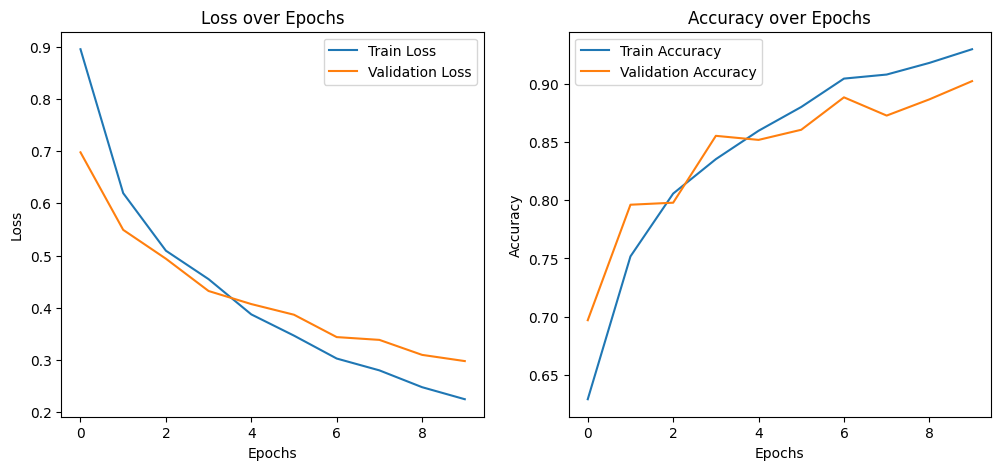


Antrenare Fold 2/5 cu augmentarea 'Basic'
Epoch 1/10: Train Loss=0.2498, Train Metric=0.9203 | Val Loss=0.1670, Val Metric=0.9634
Epoch 2/10: Train Loss=0.2063, Train Metric=0.9412 | Val Loss=0.1569, Val Metric=0.9547
Epoch 3/10: Train Loss=0.1818, Train Metric=0.9412 | Val Loss=0.1582, Val Metric=0.9582
Epoch 4/10: Train Loss=0.1541, Train Metric=0.9604 | Val Loss=0.1690, Val Metric=0.9443
Epoch 5/10: Train Loss=0.1445, Train Metric=0.9608 | Val Loss=0.1603, Val Metric=0.9599
Epoch 6/10: Train Loss=0.1275, Train Metric=0.9699 | Val Loss=0.1498, Val Metric=0.9599
Epoch 7/10: Train Loss=0.1220, Train Metric=0.9691 | Val Loss=0.1421, Val Metric=0.9617
Epoch 8/10: Train Loss=0.1100, Train Metric=0.9730 | Val Loss=0.1377, Val Metric=0.9617
Epoch 9/10: Train Loss=0.0906, Train Metric=0.9848 | Val Loss=0.1334, Val Metric=0.9686
Epoch 10/10: Train Loss=0.0804, Train Metric=0.9865 | Val Loss=0.1396, Val Metric=0.9599


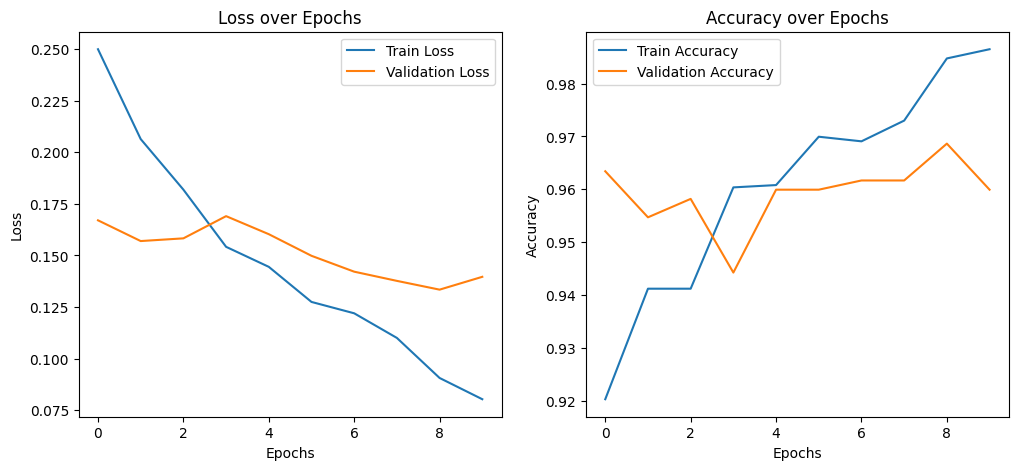


Antrenare Fold 3/5 cu augmentarea 'Basic'
Epoch 1/10: Train Loss=0.1161, Train Metric=0.9704 | Val Loss=0.0591, Val Metric=0.9948
Epoch 2/10: Train Loss=0.0850, Train Metric=0.9821 | Val Loss=0.0553, Val Metric=0.9895
Epoch 3/10: Train Loss=0.0794, Train Metric=0.9821 | Val Loss=0.0611, Val Metric=0.9878
Epoch 4/10: Train Loss=0.0654, Train Metric=0.9891 | Val Loss=0.0608, Val Metric=0.9808
Epoch 5/10: Train Loss=0.0657, Train Metric=0.9856 | Val Loss=0.0567, Val Metric=0.9895
Epoch 6/10: Train Loss=0.0545, Train Metric=0.9913 | Val Loss=0.0632, Val Metric=0.9791
Epoch 7/10: Train Loss=0.0530, Train Metric=0.9913 | Val Loss=0.0671, Val Metric=0.9791
Epoch 8/10: Train Loss=0.0448, Train Metric=0.9930 | Val Loss=0.0577, Val Metric=0.9861
Epoch 9/10: Train Loss=0.0455, Train Metric=0.9922 | Val Loss=0.0586, Val Metric=0.9826
Epoch 10/10: Train Loss=0.0404, Train Metric=0.9930 | Val Loss=0.0584, Val Metric=0.9861


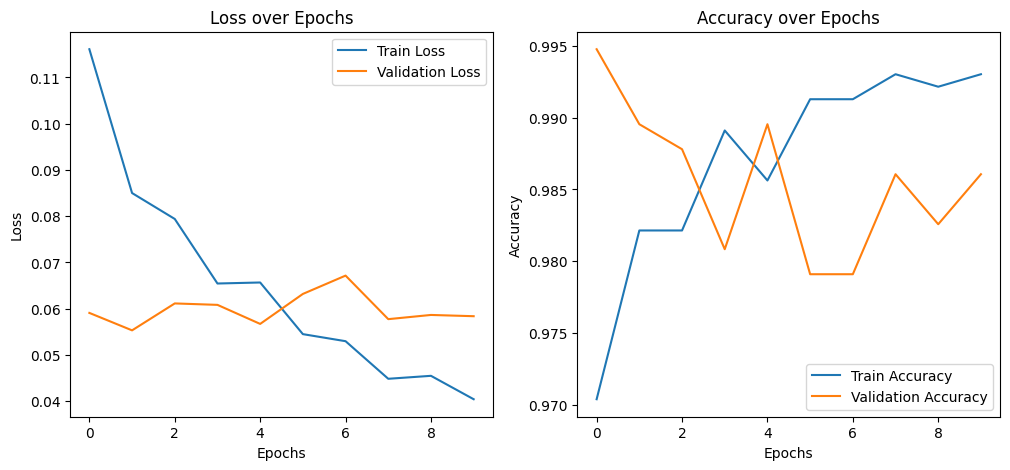


Antrenare Fold 4/5 cu augmentarea 'Basic'
Epoch 1/10: Train Loss=0.0612, Train Metric=0.9861 | Val Loss=0.0201, Val Metric=0.9965
Epoch 2/10: Train Loss=0.0483, Train Metric=0.9878 | Val Loss=0.0205, Val Metric=1.0000
Epoch 3/10: Train Loss=0.0313, Train Metric=0.9965 | Val Loss=0.0190, Val Metric=1.0000
Epoch 4/10: Train Loss=0.0315, Train Metric=0.9961 | Val Loss=0.0320, Val Metric=0.9930
Epoch 5/10: Train Loss=0.0295, Train Metric=0.9974 | Val Loss=0.0322, Val Metric=0.9948
Epoch 6/10: Train Loss=0.0263, Train Metric=0.9987 | Val Loss=0.0448, Val Metric=0.9930
Epoch 7/10: Train Loss=0.0299, Train Metric=0.9956 | Val Loss=0.0244, Val Metric=0.9965
Epoch 8/10: Train Loss=0.0218, Train Metric=0.9983 | Val Loss=0.0175, Val Metric=0.9983
Epoch 9/10: Train Loss=0.0181, Train Metric=0.9991 | Val Loss=0.0180, Val Metric=0.9983
Epoch 10/10: Train Loss=0.0194, Train Metric=0.9987 | Val Loss=0.0196, Val Metric=0.9965


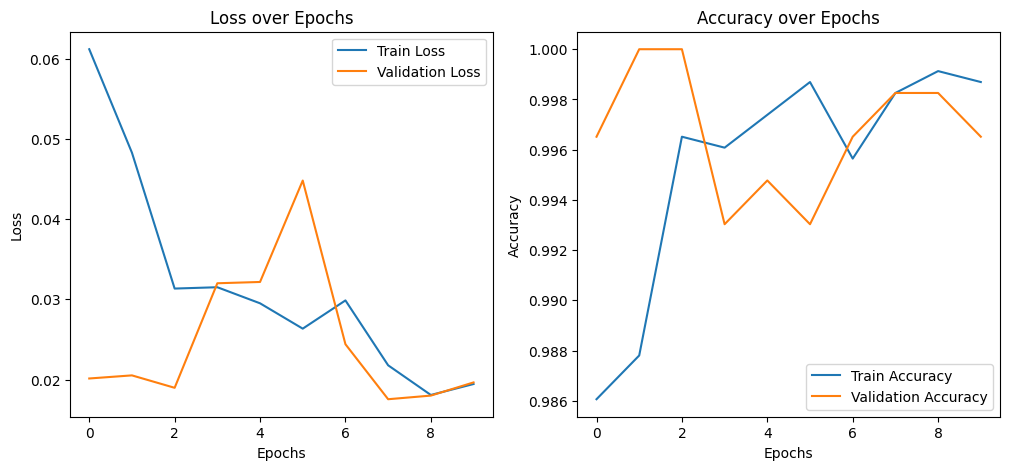


Antrenare Fold 5/5 cu augmentarea 'Basic'
Epoch 1/10: Train Loss=0.0287, Train Metric=0.9943 | Val Loss=0.0286, Val Metric=0.9930
Epoch 2/10: Train Loss=0.0226, Train Metric=0.9978 | Val Loss=0.0182, Val Metric=0.9983
Epoch 3/10: Train Loss=0.0228, Train Metric=0.9956 | Val Loss=0.0102, Val Metric=1.0000
Epoch 4/10: Train Loss=0.0156, Train Metric=0.9991 | Val Loss=0.0092, Val Metric=1.0000
Epoch 5/10: Train Loss=0.0150, Train Metric=0.9978 | Val Loss=0.0176, Val Metric=0.9965
Epoch 6/10: Train Loss=0.0126, Train Metric=0.9996 | Val Loss=0.0095, Val Metric=1.0000
Epoch 7/10: Train Loss=0.0114, Train Metric=0.9996 | Val Loss=0.0131, Val Metric=0.9983
Epoch 8/10: Train Loss=0.0120, Train Metric=0.9991 | Val Loss=0.0097, Val Metric=0.9983
Epoch 9/10: Train Loss=0.0090, Train Metric=0.9996 | Val Loss=0.0093, Val Metric=1.0000
Epoch 10/10: Train Loss=0.0107, Train Metric=0.9991 | Val Loss=0.0095, Val Metric=1.0000


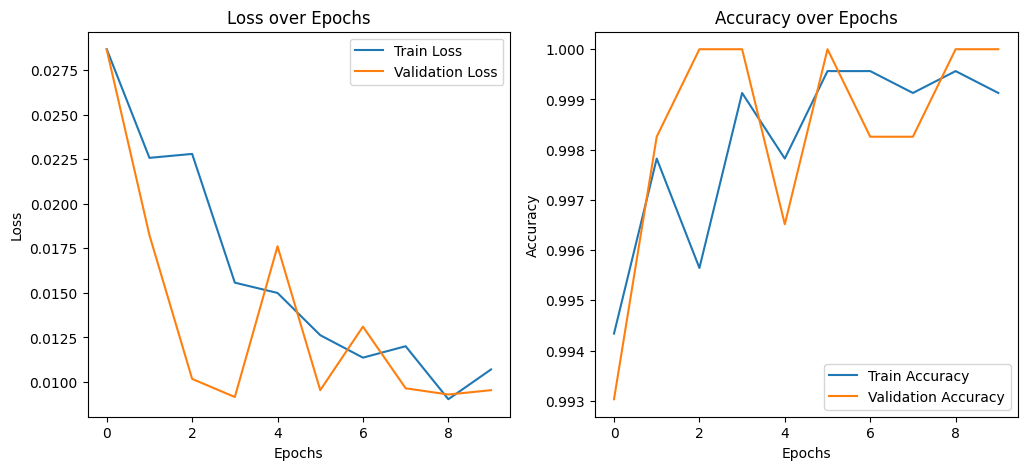


Antrenare Fold 1/5 cu augmentarea 'Flip & Noise'
Epoch 1/10: Train Loss=0.7554, Train Metric=0.7426 | Val Loss=0.4827, Val Metric=0.8014
Epoch 2/10: Train Loss=0.4980, Train Metric=0.8075 | Val Loss=0.4459, Val Metric=0.8362
Epoch 3/10: Train Loss=0.4292, Train Metric=0.8367 | Val Loss=0.3890, Val Metric=0.8449
Epoch 4/10: Train Loss=0.3944, Train Metric=0.8497 | Val Loss=0.3828, Val Metric=0.8554
Epoch 5/10: Train Loss=0.3550, Train Metric=0.8593 | Val Loss=0.3249, Val Metric=0.8571
Epoch 6/10: Train Loss=0.3406, Train Metric=0.8685 | Val Loss=0.3375, Val Metric=0.8606
Epoch 7/10: Train Loss=0.2829, Train Metric=0.8950 | Val Loss=0.2503, Val Metric=0.9042
Epoch 8/10: Train Loss=0.2779, Train Metric=0.8950 | Val Loss=0.2447, Val Metric=0.9199
Epoch 9/10: Train Loss=0.2845, Train Metric=0.8946 | Val Loss=0.2928, Val Metric=0.8780
Epoch 10/10: Train Loss=0.2733, Train Metric=0.8976 | Val Loss=0.3571, Val Metric=0.8589


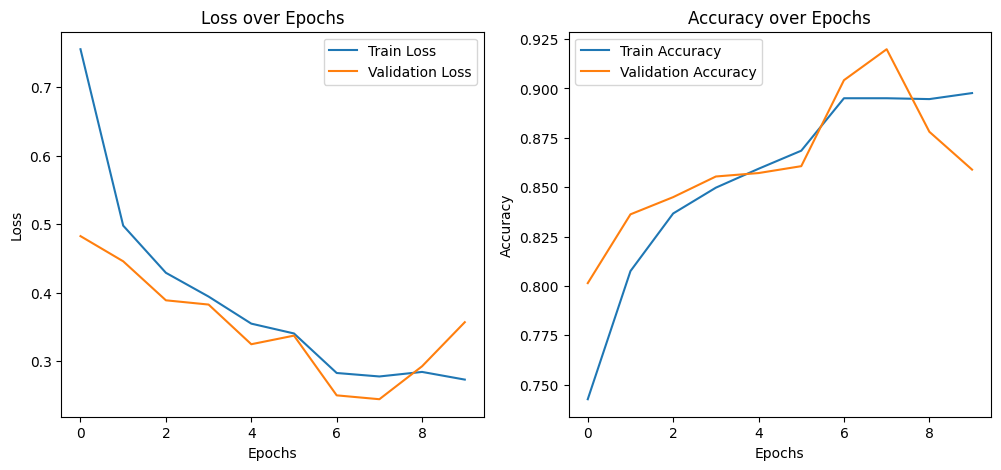


Antrenare Fold 2/5 cu augmentarea 'Flip & Noise'
Epoch 1/10: Train Loss=0.2709, Train Metric=0.8981 | Val Loss=0.1915, Val Metric=0.9373
Epoch 2/10: Train Loss=0.2423, Train Metric=0.9125 | Val Loss=0.2195, Val Metric=0.9268
Epoch 3/10: Train Loss=0.2353, Train Metric=0.9090 | Val Loss=0.2407, Val Metric=0.9094
Epoch 4/10: Train Loss=0.2209, Train Metric=0.9190 | Val Loss=0.1818, Val Metric=0.9425
Epoch 5/10: Train Loss=0.2212, Train Metric=0.9181 | Val Loss=0.1846, Val Metric=0.9408
Epoch 6/10: Train Loss=0.1973, Train Metric=0.9281 | Val Loss=0.1627, Val Metric=0.9512
Epoch 7/10: Train Loss=0.1819, Train Metric=0.9403 | Val Loss=0.1940, Val Metric=0.9321
Epoch 8/10: Train Loss=0.1866, Train Metric=0.9334 | Val Loss=0.1927, Val Metric=0.9355
Epoch 9/10: Train Loss=0.1902, Train Metric=0.9290 | Val Loss=0.2172, Val Metric=0.9199
Epoch 10/10: Train Loss=0.1635, Train Metric=0.9421 | Val Loss=0.1856, Val Metric=0.9303


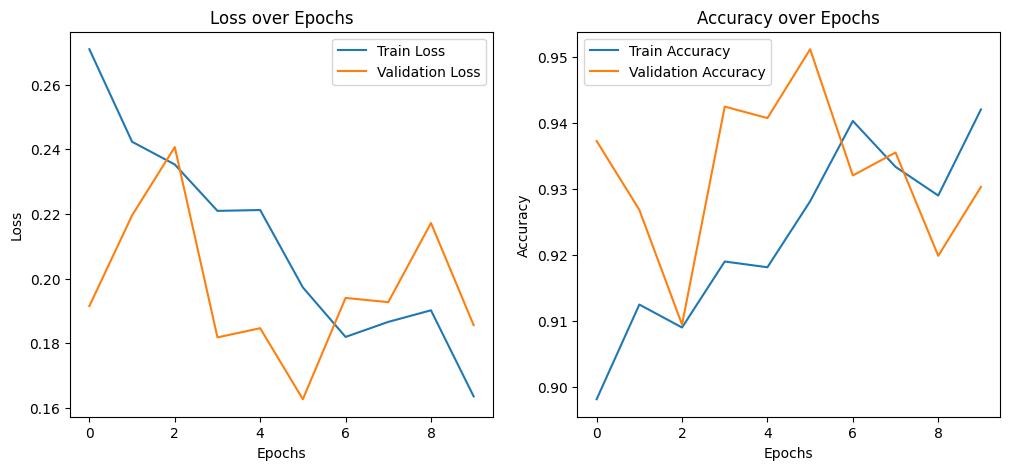


Antrenare Fold 3/5 cu augmentarea 'Flip & Noise'
Epoch 1/10: Train Loss=0.2047, Train Metric=0.9281 | Val Loss=0.1530, Val Metric=0.9390
Epoch 2/10: Train Loss=0.1635, Train Metric=0.9460 | Val Loss=0.1704, Val Metric=0.9338
Epoch 3/10: Train Loss=0.1494, Train Metric=0.9451 | Val Loss=0.1568, Val Metric=0.9355
Epoch 4/10: Train Loss=0.1582, Train Metric=0.9451 | Val Loss=0.1199, Val Metric=0.9582
Epoch 5/10: Train Loss=0.1367, Train Metric=0.9547 | Val Loss=0.0991, Val Metric=0.9686
Epoch 6/10: Train Loss=0.1355, Train Metric=0.9538 | Val Loss=0.1177, Val Metric=0.9652
Epoch 7/10: Train Loss=0.1410, Train Metric=0.9521 | Val Loss=0.1388, Val Metric=0.9564
Epoch 8/10: Train Loss=0.1213, Train Metric=0.9599 | Val Loss=0.1091, Val Metric=0.9721
Epoch 9/10: Train Loss=0.1340, Train Metric=0.9512 | Val Loss=0.1192, Val Metric=0.9547
Epoch 10/10: Train Loss=0.1261, Train Metric=0.9586 | Val Loss=0.1396, Val Metric=0.9564


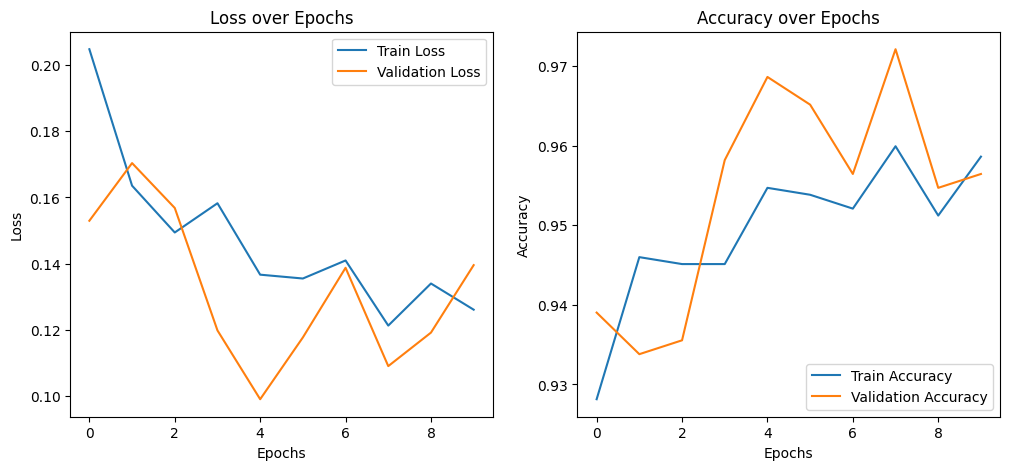


Antrenare Fold 4/5 cu augmentarea 'Flip & Noise'
Epoch 1/10: Train Loss=0.1375, Train Metric=0.9525 | Val Loss=0.0931, Val Metric=0.9721
Epoch 2/10: Train Loss=0.1176, Train Metric=0.9660 | Val Loss=0.0977, Val Metric=0.9547
Epoch 3/10: Train Loss=0.1089, Train Metric=0.9647 | Val Loss=0.0970, Val Metric=0.9704
Epoch 4/10: Train Loss=0.1036, Train Metric=0.9656 | Val Loss=0.0912, Val Metric=0.9686
Epoch 5/10: Train Loss=0.0975, Train Metric=0.9699 | Val Loss=0.0882, Val Metric=0.9669
Epoch 6/10: Train Loss=0.1028, Train Metric=0.9699 | Val Loss=0.1267, Val Metric=0.9547
Epoch 7/10: Train Loss=0.0961, Train Metric=0.9708 | Val Loss=0.0708, Val Metric=0.9826
Epoch 8/10: Train Loss=0.0842, Train Metric=0.9691 | Val Loss=0.0778, Val Metric=0.9721
Epoch 9/10: Train Loss=0.0798, Train Metric=0.9774 | Val Loss=0.0857, Val Metric=0.9721
Epoch 10/10: Train Loss=0.0892, Train Metric=0.9717 | Val Loss=0.1125, Val Metric=0.9582


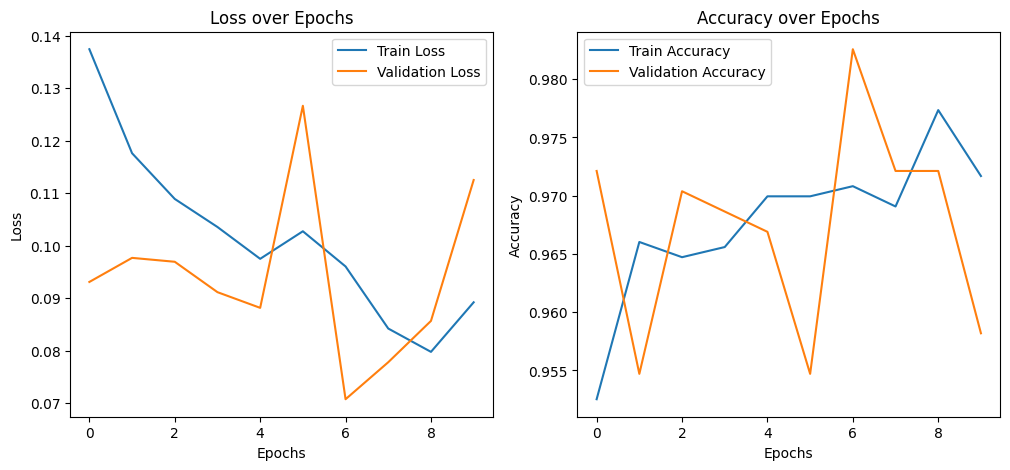


Antrenare Fold 5/5 cu augmentarea 'Flip & Noise'
Epoch 1/10: Train Loss=0.0913, Train Metric=0.9678 | Val Loss=0.0545, Val Metric=0.9861
Epoch 2/10: Train Loss=0.0796, Train Metric=0.9765 | Val Loss=0.0575, Val Metric=0.9756
Epoch 3/10: Train Loss=0.0853, Train Metric=0.9708 | Val Loss=0.0517, Val Metric=0.9861
Epoch 4/10: Train Loss=0.0744, Train Metric=0.9778 | Val Loss=0.0593, Val Metric=0.9861
Epoch 5/10: Train Loss=0.0829, Train Metric=0.9765 | Val Loss=0.0613, Val Metric=0.9878
Epoch 6/10: Train Loss=0.0684, Train Metric=0.9813 | Val Loss=0.0709, Val Metric=0.9774
Epoch 7/10: Train Loss=0.0873, Train Metric=0.9721 | Val Loss=0.0580, Val Metric=0.9808
Epoch 8/10: Train Loss=0.0769, Train Metric=0.9756 | Val Loss=0.0872, Val Metric=0.9721
Epoch 9/10: Train Loss=0.0676, Train Metric=0.9800 | Val Loss=0.0821, Val Metric=0.9704
Epoch 10/10: Train Loss=0.0622, Train Metric=0.9839 | Val Loss=0.0676, Val Metric=0.9721


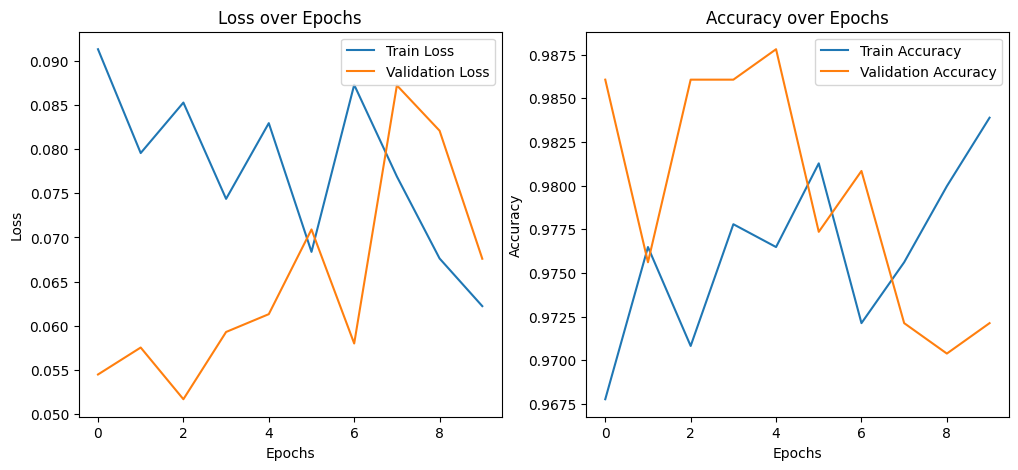


Antrenare Fold 1/5 cu augmentarea 'Rotation & Elastic'
Epoch 1/10: Train Loss=0.4506, Train Metric=0.8341 | Val Loss=0.3440, Val Metric=0.8746
Epoch 2/10: Train Loss=0.3971, Train Metric=0.8510 | Val Loss=0.3560, Val Metric=0.8606
Epoch 3/10: Train Loss=0.3726, Train Metric=0.8602 | Val Loss=0.2830, Val Metric=0.8955
Epoch 4/10: Train Loss=0.3466, Train Metric=0.8659 | Val Loss=0.3084, Val Metric=0.8902
Epoch 5/10: Train Loss=0.3380, Train Metric=0.8685 | Val Loss=0.3037, Val Metric=0.8763
Epoch 6/10: Train Loss=0.3178, Train Metric=0.8720 | Val Loss=0.2967, Val Metric=0.8780
Epoch 7/10: Train Loss=0.3165, Train Metric=0.8711 | Val Loss=0.2914, Val Metric=0.8885
Epoch 8/10: Train Loss=0.3040, Train Metric=0.8872 | Val Loss=0.2792, Val Metric=0.8833
Epoch 9/10: Train Loss=0.3170, Train Metric=0.8750 | Val Loss=0.2676, Val Metric=0.9111
Epoch 10/10: Train Loss=0.3230, Train Metric=0.8754 | Val Loss=0.3323, Val Metric=0.8641


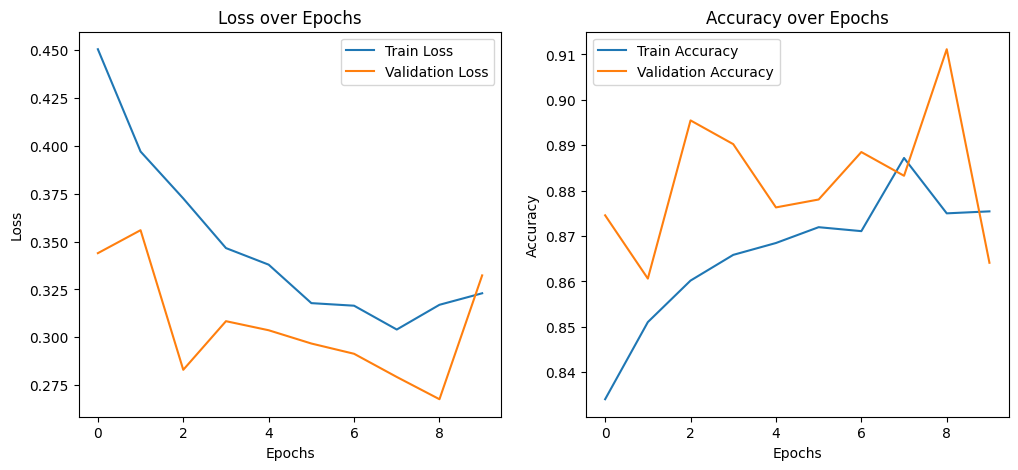


Antrenare Fold 2/5 cu augmentarea 'Rotation & Elastic'
Epoch 1/10: Train Loss=0.3262, Train Metric=0.8754 | Val Loss=0.2956, Val Metric=0.8955
Epoch 2/10: Train Loss=0.2889, Train Metric=0.8946 | Val Loss=0.3416, Val Metric=0.8659
Epoch 3/10: Train Loss=0.2959, Train Metric=0.8881 | Val Loss=0.4107, Val Metric=0.8275
Epoch 4/10: Train Loss=0.2958, Train Metric=0.8872 | Val Loss=0.2592, Val Metric=0.9042
Epoch 5/10: Train Loss=0.2637, Train Metric=0.9046 | Val Loss=0.2710, Val Metric=0.8902
Epoch 6/10: Train Loss=0.2559, Train Metric=0.9055 | Val Loss=0.2259, Val Metric=0.9077
Epoch 7/10: Train Loss=0.2493, Train Metric=0.9133 | Val Loss=0.2813, Val Metric=0.8850
Epoch 8/10: Train Loss=0.2590, Train Metric=0.8990 | Val Loss=0.2954, Val Metric=0.9007
Epoch 9/10: Train Loss=0.2495, Train Metric=0.9037 | Val Loss=0.2744, Val Metric=0.9024
Epoch 10/10: Train Loss=0.2541, Train Metric=0.9042 | Val Loss=0.2649, Val Metric=0.8868


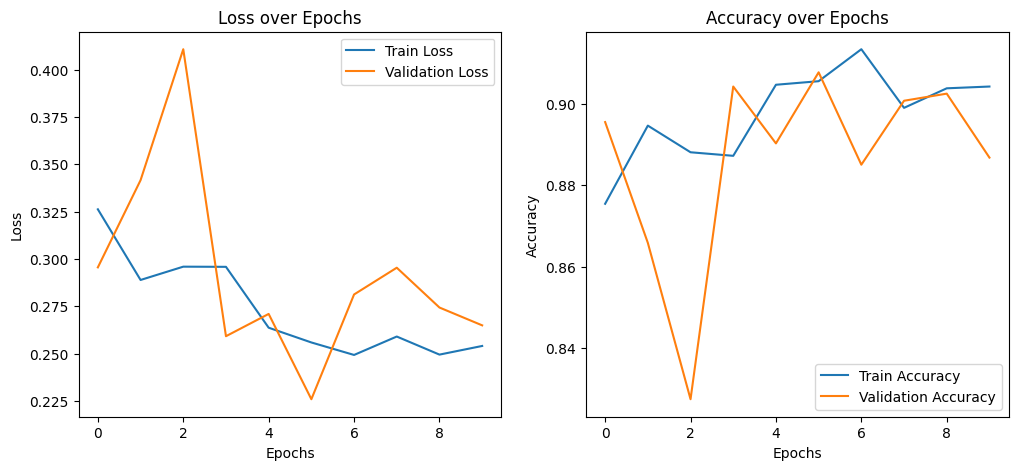


Antrenare Fold 3/5 cu augmentarea 'Rotation & Elastic'
Epoch 1/10: Train Loss=0.2733, Train Metric=0.8976 | Val Loss=0.2814, Val Metric=0.8815
Epoch 2/10: Train Loss=0.2494, Train Metric=0.8963 | Val Loss=0.2970, Val Metric=0.8815
Epoch 3/10: Train Loss=0.2493, Train Metric=0.9064 | Val Loss=0.2083, Val Metric=0.9216
Epoch 4/10: Train Loss=0.2497, Train Metric=0.9090 | Val Loss=0.1719, Val Metric=0.9443
Epoch 5/10: Train Loss=0.2369, Train Metric=0.9094 | Val Loss=0.1598, Val Metric=0.9443
Epoch 6/10: Train Loss=0.2361, Train Metric=0.9181 | Val Loss=0.2405, Val Metric=0.9024
Epoch 7/10: Train Loss=0.2520, Train Metric=0.9090 | Val Loss=0.2644, Val Metric=0.9024
Epoch 8/10: Train Loss=0.2351, Train Metric=0.9090 | Val Loss=0.2884, Val Metric=0.8972
Epoch 9/10: Train Loss=0.2440, Train Metric=0.9125 | Val Loss=0.1928, Val Metric=0.9233
Epoch 10/10: Train Loss=0.2413, Train Metric=0.9085 | Val Loss=0.2289, Val Metric=0.9146


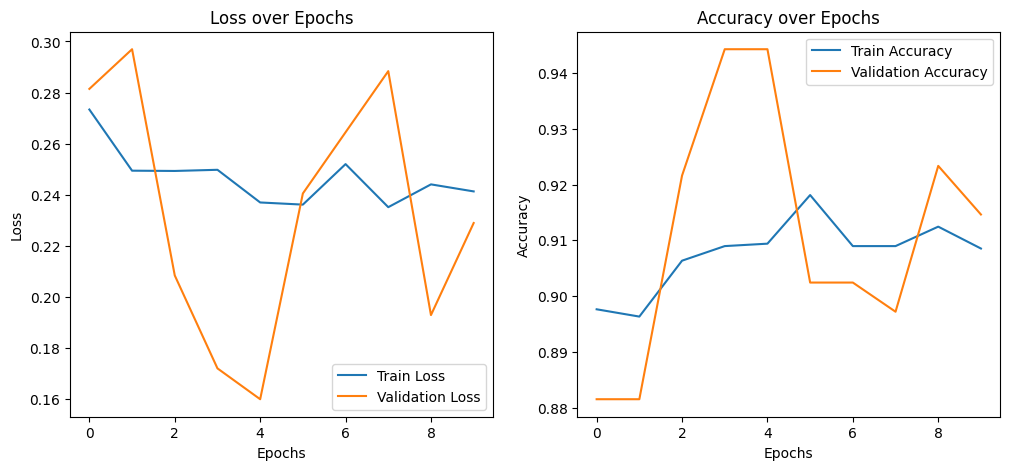


Antrenare Fold 4/5 cu augmentarea 'Rotation & Elastic'
Epoch 1/10: Train Loss=0.2588, Train Metric=0.9059 | Val Loss=0.2397, Val Metric=0.8920
Epoch 2/10: Train Loss=0.2232, Train Metric=0.9164 | Val Loss=0.3050, Val Metric=0.8798
Epoch 3/10: Train Loss=0.2428, Train Metric=0.9072 | Val Loss=0.1876, Val Metric=0.9355
Epoch 4/10: Train Loss=0.2382, Train Metric=0.9068 | Val Loss=0.2368, Val Metric=0.9024
Epoch 5/10: Train Loss=0.2166, Train Metric=0.9229 | Val Loss=0.1590, Val Metric=0.9425
Epoch 6/10: Train Loss=0.1986, Train Metric=0.9255 | Val Loss=0.1674, Val Metric=0.9268
Epoch 7/10: Train Loss=0.2216, Train Metric=0.9216 | Val Loss=0.2178, Val Metric=0.9233
Epoch 8/10: Train Loss=0.2239, Train Metric=0.9116 | Val Loss=0.2410, Val Metric=0.9007
Epoch 9/10: Train Loss=0.2187, Train Metric=0.9172 | Val Loss=0.1850, Val Metric=0.9321
Epoch 10/10: Train Loss=0.2231, Train Metric=0.9212 | Val Loss=0.2112, Val Metric=0.9129


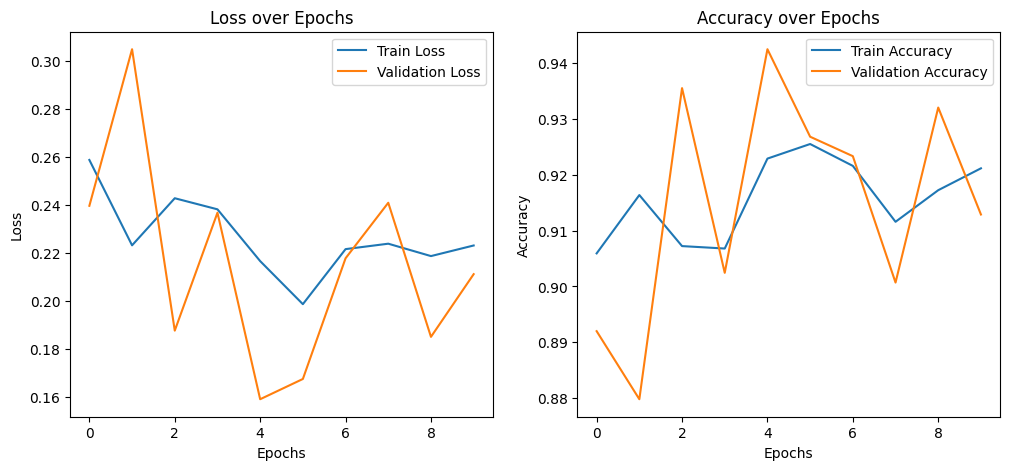


Antrenare Fold 5/5 cu augmentarea 'Rotation & Elastic'
Epoch 1/10: Train Loss=0.2193, Train Metric=0.9133 | Val Loss=0.2061, Val Metric=0.9181
Epoch 2/10: Train Loss=0.1849, Train Metric=0.9290 | Val Loss=0.2615, Val Metric=0.8990
Epoch 3/10: Train Loss=0.2048, Train Metric=0.9260 | Val Loss=0.1680, Val Metric=0.9338
Epoch 4/10: Train Loss=0.2159, Train Metric=0.9260 | Val Loss=0.1915, Val Metric=0.9146
Epoch 5/10: Train Loss=0.2107, Train Metric=0.9238 | Val Loss=0.2052, Val Metric=0.9111
Epoch 6/10: Train Loss=0.1888, Train Metric=0.9312 | Val Loss=0.1901, Val Metric=0.9216
Epoch 7/10: Train Loss=0.1948, Train Metric=0.9264 | Val Loss=0.1985, Val Metric=0.9094
Epoch 8/10: Train Loss=0.2029, Train Metric=0.9238 | Val Loss=0.2880, Val Metric=0.9042
Epoch 9/10: Train Loss=0.2081, Train Metric=0.9220 | Val Loss=0.4011, Val Metric=0.8415
Epoch 10/10: Train Loss=0.2041, Train Metric=0.9225 | Val Loss=0.1993, Val Metric=0.9111


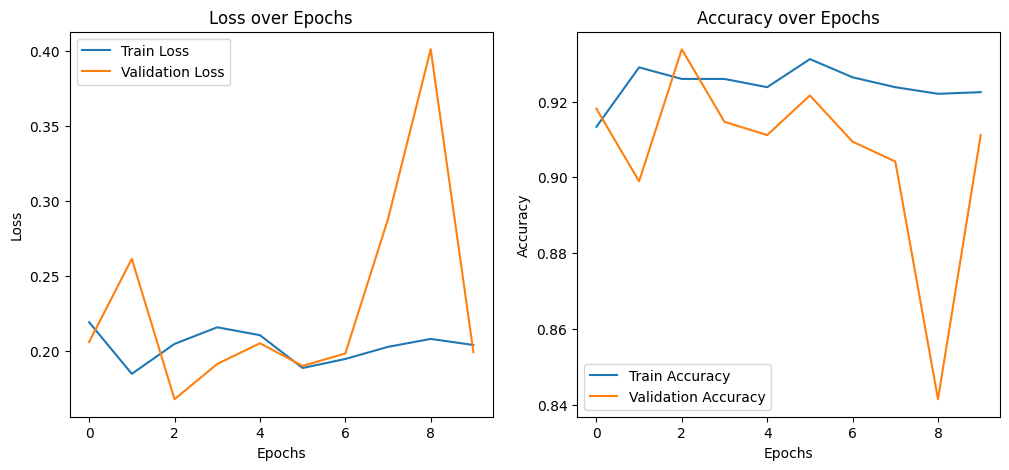


Rezultatele au fost salvate în 'augmentation_results.csv'.

Metricile medii pentru fiecare augmentare:
         augmentation  accuracy  precision    recall  f1_score       auc
0               Basic  0.714721   0.794364  0.706173  0.670535  0.856907
1        Flip & Noise  0.680711   0.746555  0.671572  0.639488  0.835016
2  Rotation & Elastic  0.635533   0.707372  0.625047  0.602014  0.818391

Cele mai bune performanțe au fost obținute cu augmentarea:
augmentation       Basic
accuracy        0.714721
precision       0.794364
recall          0.706173
f1_score        0.670535
auc             0.856907
Name: 0, dtype: object


In [398]:
def main():
    data_dir = "/home/regelepirat/IS/Proiect/etapa2/data"
    k_fold_dir = os.path.join(data_dir, "K_Folds")
    test_dir = os.path.join(data_dir, "Testing")
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

    params_model = {
        "shape_in": (3, 256, 256),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 4,
    }

    # cnn model
    model = CNN_BRAIN_TUMOR(params_model).to("cuda")
    print("Model creat cu succes.")

    # load K_folds
    fold_dataloaders = load_fold_dataloaders(k_fold_dir, test_dir, categories, transform=None)

    # compare aug
    augmentation_results, mean_results = compare_augmentations(
        model, fold_dataloaders, augmentations, epochs=10, device="cuda"
    )

    print("\nCele mai bune performante au fost obtinute cu augmentarea:")
    best_augmentation = mean_results.loc[mean_results["f1_score"].idxmax()]
    print(best_augmentation)


if __name__ == "__main__":
    main()

## Cerinta 4

In [25]:
import os
import time
import copy
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt


class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
        for label, category in enumerate(categories):
            category_dir = os.path.join(root_dir, category)
            if os.path.exists(category_dir):
                for img_name in os.listdir(category_dir):
                    img_path = os.path.join(category_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [27]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
# find worst fold
fold_metrics = pd.read_csv("fold_metrics_validation_and_test.csv")
# worst_fold_idx = fold_metrics["F1-Score_Validation"].idxmin()
worst_fold_idx = fold_metrics["f1_score"].idxmin()
print(f"Cel mai slab fold: Fold {worst_fold_idx + 1}")

Cel mai slab fold: Fold 1


In [562]:
worst_fold_dir = os.path.join("data/K_Folds", f"Fold_{worst_fold_idx + 1}")
train_dataset = BrainTumorDataset(root_dir=f"{worst_fold_dir}/Train", transform=transform)
val_dataset = BrainTumorDataset(root_dir=f"{worst_fold_dir}/Validation", transform=transform)
test_dataset = BrainTumorDataset(root_dir="data/Testing", transform=transform)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss >= self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered!")
        else:
            self.best_loss = val_loss
            self.counter = 0

In [564]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    pred = output.argmax(dim=1)
    correct = pred.eq(target).sum().item()
    if opt:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), correct

In [565]:
# calc loss and acc for one epoch
def loss_epoch(model, loss_func, dataloader, optimizer=None):
    total_loss = 0.0
    total_correct = 0
    total_samples = len(dataloader.dataset)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [31]:
# trai funct for early stopping
def train_with_early_stopping(model, params, verbose=False):
    epochs = params["epochs"]
    train_dl = params["train"]
    val_dl = params["val"]
    optimizer = params["optimizer"]
    loss_func = params["loss_func"]
    patience = params.get("patience", 5)

    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = loss_epoch(model, loss_func, train_dl, optimizer)
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = loss_epoch(model, loss_func, val_dl)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), params["weight_path"])
        early_stopping(val_loss)
        if early_stopping.early_stop:
            if verbose:
                print("Early stopping triggered!")
            break
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    elapsed_time = time.time() - start_time
    model.load_state_dict(best_model_wts)
    return model, history, elapsed_time

# train funct for LR scheduler
def train_with_lr_scheduler(model, params, scheduler_type, verbose=False):
    epochs = params["epochs"]
    train_dl = params["train"]
    val_dl = params["val"]
    optimizer = params["optimizer"]
    loss_func = params["loss_func"]
    scheduler = params["scheduler"]
    patience = params.get("patience", 5)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = loss_epoch(model, loss_func, train_dl, optimizer)
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = loss_epoch(model, loss_func, val_dl)

        # save best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), params["weight_path"])

        # actualize scheduler
        if scheduler_type == "plateau_lr":
            scheduler.step(val_loss)  
        else:
            scheduler.step()  

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    elapsed_time = time.time() - start_time
    model.load_state_dict(best_model_wts)
    return model, history, elapsed_time



In [35]:
def Ture_and_Pred(test_loader, model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred


Testing Technique: PLATEAU_LR on Fold 1
Epoch 1/30 - Train Loss: 1.1551, Val Loss: 0.6874, Train Acc: 0.5618, Val Acc: 0.7056
Epoch 2/30 - Train Loss: 0.6989, Val Loss: 0.5815, Train Acc: 0.6908, Val Acc: 0.7474
Epoch 3/30 - Train Loss: 0.6257, Val Loss: 0.5637, Train Acc: 0.7409, Val Acc: 0.7544
Epoch 4/30 - Train Loss: 0.5548, Val Loss: 0.5356, Train Acc: 0.7683, Val Acc: 0.7648
Epoch 5/30 - Train Loss: 0.4721, Val Loss: 0.4667, Train Acc: 0.8110, Val Acc: 0.8188
Epoch 6/30 - Train Loss: 0.4118, Val Loss: 0.4132, Train Acc: 0.8349, Val Acc: 0.8275
Epoch 7/30 - Train Loss: 0.4025, Val Loss: 0.4167, Train Acc: 0.8371, Val Acc: 0.8345
Epoch 8/30 - Train Loss: 0.3459, Val Loss: 0.4439, Train Acc: 0.8584, Val Acc: 0.8188
Epoch 9/30 - Train Loss: 0.3254, Val Loss: 0.5658, Train Acc: 0.8624, Val Acc: 0.7857
Epoch 10/30 - Train Loss: 0.2261, Val Loss: 0.3167, Train Acc: 0.9094, Val Acc: 0.8815
Epoch 11/30 - Train Loss: 0.2147, Val Loss: 0.3019, Train Acc: 0.9168, Val Acc: 0.8902
Epoch 12/30

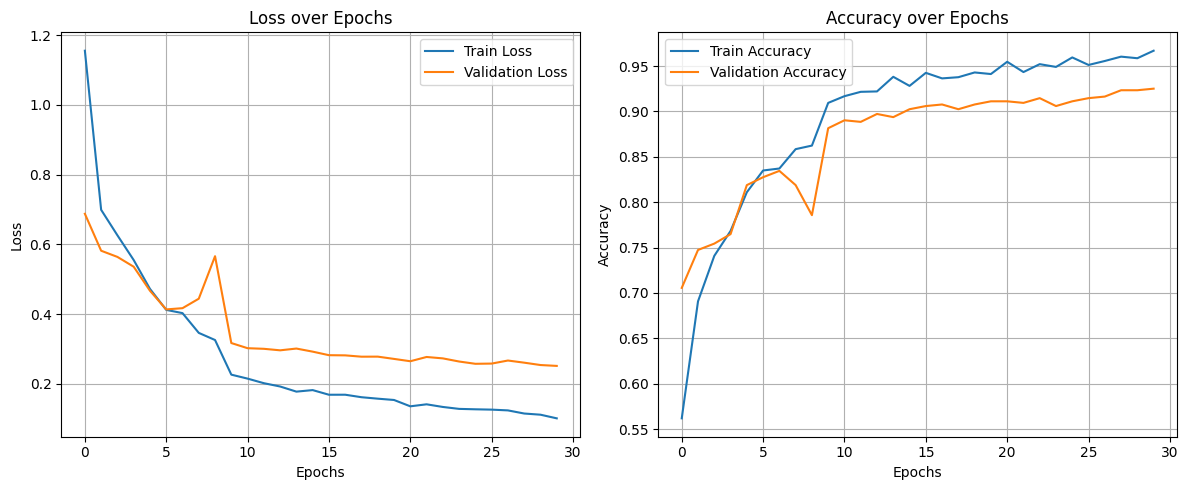


Summary of Techniques:
    Technique  Train Time (s)  Precision    Recall  F1-Score  Accuracy
0  plateau_lr      213.827009   0.789172  0.694385  0.666063  0.708122


In [573]:
def plot_train_val_graphs(loss_history, metric_history):
    plt.figure(figsize=(12, 5))
    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_history["train"], label="Train Loss")
    plt.plot(loss_history["val"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metric_history["train"], label="Train Accuracy")
    plt.plot(metric_history["val"], label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    
# cnn model
cnn_model = CNN_BRAIN_TUMOR(params_model) 
cnn_model.to(device) 

# optimizer
learning_rate = 0.001
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)  


techniques = [ "plateau_lr"]
results_comparison = []

for technique in techniques:
    print(f"\n{'='*40}")
    print(f"Testing Technique: {technique.upper()} on Fold {worst_fold_idx + 1}")
    print(f"{'='*40}")
    
    # reinitialize model and optimizer for each technique
    cnn_model = CNN_BRAIN_TUMOR(params_model)  
    cnn_model.to(device)
    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
    
    # params
    params = {
        "epochs": 30,
        "train": train_dl,
        "val": val_dl,
        "optimizer": optimizer,
        "loss_func": nn.CrossEntropyLoss(),
        "scheduler": None,
        "weight_path": f"./best_model_{technique}.pth",
        "patience": 5
    }
    
    
    if technique == "early_stopping":
        model, history, elapsed_time = train_with_early_stopping(cnn_model, params, verbose=True)
    else:
        scheduler = (
            StepLR(optimizer, step_size=10, gamma=0.5)
            if technique == "step_lr"
            else ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)
        )
        params["scheduler"] = scheduler
        model, history, elapsed_time = train_with_lr_scheduler(
            cnn_model, params, scheduler_type=technique, verbose=True
        )
        
    y_true, y_pred = Ture_and_Pred(test_dl, model)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)
    results_comparison.append({
        "Technique": technique,
        "Train Time (s)": elapsed_time,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": accuracy
    })
    print(f"\nResults for {technique.upper()}:\n"
          f"Train Time: {elapsed_time:.2f}s\n"
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}\n")
    plot_train_val_graphs(
        loss_history={"train": history["train_loss"], "val": history["val_loss"]},
        metric_history={"train": history["train_acc"], "val": history["val_acc"]}
    )

# save to csv
results_df = pd.DataFrame(results_comparison)
results_df.to_csv("results_comparison.csv", index=False)
print("\nSummary of Techniques:")
print(results_df)


## Cerinta 5

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt

# focal loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
def one_hot_encoding(labels, num_classes):
    return torch.eye(num_classes, device=labels.device)[labels]


In [10]:
# loss epochs one hot support
def loss_epoch(model, loss_func, dataloader, optimizer=None, num_classes=4):
    total_loss = 0.0
    total_correct = 0
    total_samples = len(dataloader.dataset)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        if isinstance(loss_func, nn.BCEWithLogitsLoss):
            labels = one_hot_encoding(labels, num_classes)

        outputs = model(images)
        loss = loss_func(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)

        total_correct += (preds == labels.argmax(dim=1) if isinstance(loss_func, nn.BCEWithLogitsLoss) else preds == labels).sum().item()

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [11]:
# loss functions
loss_functions = {
    "CrossEntropyLoss": nn.CrossEntropyLoss(),
    "BCEWithLogitsLoss": nn.BCEWithLogitsLoss(),
    "FocalLoss (α=0.25, γ=2.0)": FocalLoss(alpha=0.25, gamma=2.0)
}

augmentations = {
    "Minimal": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "Advanced": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "Complex": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        PreprocessImageOptimized(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


# optimizers
optimizers = {
    "Adam": torch.optim.Adam,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop
}

In [29]:
# datasets
worst_fold_dir = os.path.join("data/K_Folds", f"Fold_{worst_fold_idx + 1}")
train_dataset = BrainTumorDataset(root_dir=f"{worst_fold_dir}/Train", transform=transform)
val_dataset = BrainTumorDataset(root_dir=f"{worst_fold_dir}/Validation", transform=transform)
test_dataset = BrainTumorDataset(root_dir="data/Testing", transform=transform)

# dataloaders
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
def Ture_and_Prob(dataloader, model):
   
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probabilities.cpu().numpy())

    return np.array(y_true), np.array(y_probs)


In [44]:
from sklearn.metrics import roc_auc_score, classification_report

def calculate_auc_per_class(y_true, y_probs, num_classes):
    auc_per_class = {}
    for class_idx in range(num_classes):
        class_true = (y_true == class_idx).astype(int)
        class_probs = y_probs[:, class_idx]
        auc = roc_auc_score(class_true, class_probs) if len(set(class_true)) > 1 else "N/A"
        auc_per_class[f"Class {class_idx}"] = auc
    return auc_per_class

# ablation study results
results_loss = []
results_augmentations = []
results_optimizers = []

# nr classes
num_classes = 4

# eval loss funct
for loss_name, loss_func in loss_functions.items():
    print(f"\nTesting Loss Function: {loss_name}")
    cnn_model = CNN_BRAIN_TUMOR(params_model)
    cnn_model.to(device)
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

    params = {
        "epochs": 15,
        "train": train_dl,
        "val": val_dl,
        "optimizer": optimizer,
        "loss_func": loss_func,
        "scheduler": None,
        "weight_path": f"./best_model_loss_{loss_name}.pth",
        "patience": 5
    }

    model, history, elapsed_time = train_with_early_stopping(cnn_model, params, verbose=True)

    # calc metrics for val
    y_true_val, y_probs_val = Ture_and_Prob(val_dl, model)
    y_pred_val = y_probs_val.argmax(axis=1)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    # calc metrics for test
    y_true_test, y_probs_test = Ture_and_Prob(test_dl, model)
    y_pred_test = y_probs_test.argmax(axis=1)

    auc_per_class_test = calculate_auc_per_class(y_true_test, y_probs_test, num_classes)
    classification_metrics_test = classification_report(y_true_test, y_pred_test, output_dict=True)

    results_loss.append({
        "Loss Function": loss_name,
        "Train Time (s)": elapsed_time,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": accuracy_score(y_true_test, y_pred_test),
        "Precision": precision_score(y_true_test, y_pred_test, average="macro"),
        "Recall": recall_score(y_true_test, y_pred_test, average="macro"),
        "F1-Score": f1_score(y_true_test, y_pred_test, average="macro"),
        "AUC Per Class": auc_per_class_test,
        "Class Metrics": classification_metrics_test
    })


# eval augmentations
for aug_name, transform in augmentations.items():
    print(f"\nTesting Augmentation: {aug_name}")
    train_dataset = BrainTumorDataset(root_dir=f"{worst_fold_dir}/Train", transform=transform)
    train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)

    cnn_model = CNN_BRAIN_TUMOR(params_model)
    cnn_model.to(device)
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

    params = {
        "epochs": 15,
        "train": train_dl,
        "val": val_dl,
        "optimizer": optimizer,
        "loss_func": nn.CrossEntropyLoss(),
        "scheduler": None,
        "weight_path": f"./best_model_aug_{aug_name}.pth",
        "patience": 5
    }

    model, history, elapsed_time = train_with_early_stopping(cnn_model, params, verbose=True)

    # calc metrics for val 
    y_true_val, y_probs_val = Ture_and_Prob(val_dl, model)
    y_pred_val = y_probs_val.argmax(axis=1)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    # calc metrics for  test
    y_true_test, y_probs_test = Ture_and_Prob(test_dl, model)
    y_pred_test = y_probs_test.argmax(axis=1)

    auc_per_class_test = calculate_auc_per_class(y_true_test, y_probs_test, num_classes)
    classification_metrics_test = classification_report(y_true_test, y_pred_test, output_dict=True)

    results_augmentations.append({
        "Augmentation": aug_name,
        "Train Time (s)": elapsed_time,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": accuracy_score(y_true_test, y_pred_test),
        "Precision": precision_score(y_true_test, y_pred_test, average="macro"),
        "Recall": recall_score(y_true_test, y_pred_test, average="macro"),
        "F1-Score": f1_score(y_true_test, y_pred_test, average="macro"),
        "AUC Per Class": auc_per_class_test,
        "Class Metrics": classification_metrics_test
    })


# eval optimizers
for opt_name, opt_class in optimizers.items():
    print(f"\nTesting Optimizer: {opt_name}")
    cnn_model = CNN_BRAIN_TUMOR(params_model)
    cnn_model.to(device)
    optimizer = opt_class(cnn_model.parameters(), lr=0.001)

    params = {
        "epochs": 15,
        "train": train_dl,
        "val": val_dl,
        "optimizer": optimizer,
        "loss_func": nn.CrossEntropyLoss(),
        "scheduler": None,
        "weight_path": f"./best_model_opt_{opt_name}.pth",
        "patience": 5
    }

    # train
    model, history, elapsed_time = train_with_early_stopping(cnn_model, params, verbose=True)

    # eval on validation
    y_true_val, y_probs_val = Ture_and_Prob(val_dl, model)
    y_pred_val = y_probs_val.argmax(axis=1)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)

    # eval on test
    y_true_test, y_probs_test = Ture_and_Prob(test_dl, model)
    y_pred_test = y_probs_test.argmax(axis=1)

    # calc metrics
    auc_per_class_test = calculate_auc_per_class(y_true_test, y_probs_test, num_classes)
    classification_metrics_test = classification_report(y_true_test, y_pred_test, output_dict=True)

    # save results
    results_optimizers.append({
        "Optimizer": opt_name,
        "Train Time (s)": elapsed_time,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": accuracy_score(y_true_test, y_pred_test),
        "Precision": precision_score(y_true_test, y_pred_test, average="macro"),
        "Recall": recall_score(y_true_test, y_pred_test, average="macro"),
        "F1-Score": f1_score(y_true_test, y_pred_test, average="macro"),
        "AUC Per Class": auc_per_class_test,
        "Class Metrics": classification_metrics_test
    })


df_loss = pd.DataFrame(results_loss)
df_augmentations = pd.DataFrame(results_augmentations)
df_optimizers = pd.DataFrame(results_optimizers)

df_loss.to_csv("ablation_loss.csv", index=False)
df_augmentations.to_csv("ablation_augmentations.csv", index=False)
df_optimizers.to_csv("ablation_optimizers.csv", index=False)

print("\nImpactul Functiilor de Pierdere:")
print(df_loss)
print("\nImpactul Augmentarilor:")
print(df_augmentations)
print("\nImpactul Optimizatorilor:")
print(df_optimizers)




Testing Loss Function: CrossEntropyLoss
Epoch 1/15 - Train Loss: 1.2683, Val Loss: 1.7512, Train Acc: 0.5183, Val Acc: 0.3136
Epoch 2/15 - Train Loss: 0.8004, Val Loss: 2.8033, Train Acc: 0.6450, Val Acc: 0.3415
Epoch 3/15 - Train Loss: 0.7307, Val Loss: 3.5162, Train Acc: 0.6855, Val Acc: 0.3049
Epoch 4/15 - Train Loss: 0.6422, Val Loss: 4.9668, Train Acc: 0.7265, Val Acc: 0.2979
Epoch 5/15 - Train Loss: 0.6029, Val Loss: 5.8767, Train Acc: 0.7435, Val Acc: 0.2927
Early stopping triggered!
Early stopping triggered!

Testing Loss Function: BCEWithLogitsLoss
Epoch 1/15 - Train Loss: 0.4989, Val Loss: 0.7723, Train Acc: 0.5226, Val Acc: 0.3293
Epoch 2/15 - Train Loss: 0.3585, Val Loss: 1.6092, Train Acc: 0.6668, Val Acc: 0.3467
Epoch 3/15 - Train Loss: 0.3165, Val Loss: 2.1743, Train Acc: 0.7247, Val Acc: 0.3293
Epoch 4/15 - Train Loss: 0.2761, Val Loss: 2.3901, Train Acc: 0.7657, Val Acc: 0.3415
Epoch 5/15 - Train Loss: 0.2582, Val Loss: 2.5138, Train Acc: 0.7792, Val Acc: 0.2003
Early

In [45]:
# results
df_loss = pd.DataFrame(results_loss)
df_augmentations = pd.DataFrame(results_augmentations)
df_optimizers = pd.DataFrame(results_optimizers)

print("\nImpactul Functiilor de Pierdere:")
print(df_loss)
print("\nImpactul Augmentarilor:")
print(df_augmentations)
print("\nImpactul Optimizatorilor:")
print(df_optimizers)

# save to csv
df_loss.to_csv("ablation_loss.csv", index=False)
df_augmentations.to_csv("ablation_augmentations.csv", index=False)
df_optimizers.to_csv("ablation_optimizers.csv", index=False)


Impactul Funcțiilor de Pierdere:
               Loss Function  Train Time (s)  Validation Accuracy  \
0           CrossEntropyLoss       89.623129             0.313589   
1          BCEWithLogitsLoss       83.750066             0.329268   
2  FocalLoss (α=0.25, γ=2.0)       84.742151             0.301394   

   Test Accuracy  Precision    Recall  F1-Score  \
0       0.241117   0.237938  0.235722  0.190045   
1       0.190355   0.247867  0.187610  0.160447   
2       0.289340   0.297597  0.280292  0.196803   

                                       AUC Per Class  \
0  {'Class 0': 0.46969387755102043, 'Class 1': 0....   
1  {'Class 0': 0.49744897959183676, 'Class 1': 0....   
2  {'Class 0': 0.4845238095238096, 'Class 1': 0.5...   

                                       Class Metrics  
0  {'0': {'precision': 0.2509505703422053, 'recal...  
1  {'0': {'precision': 0.2145922746781116, 'recal...  
2  {'0': {'precision': 0.28434504792332266, 'reca...  

Impactul Augmentărilor:
  Augmentation